In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import csv
import os
import math
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

from scipy import ndimage
pylab.rcParams['figure.figsize'] = 8, 6

In [2]:
from IPython.display import display, HTML

CSS = """
div.cell:nth-child(18) .output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
dd_dict_file = os.path.join(os.pardir, "data", "pc_latlon_dd.csv")
parti_file = os.path.join(os.pardir, "data", "DS1_Intern_20170101.csv")
mrt_file = os.path.join(os.pardir, "data", "mrt_2016.csv")

In [4]:
dd_dict_df = pd.read_csv(dd_dict_file, dtype={'postalcode': 'str'})
parti_df = pd.read_csv(parti_file, dtype={'PostalCode': 'str'})
print(type(parti_df['PostalCode'].dtype))
print(type(parti_df['PostalCode'][0]))
print(len(dd_dict_df))
dd_dict_df['geocoding_failed'] = dd_dict_df['homelat'].isnull()
dd_dict_df.loc[dd_dict_df['geocoding_failed'] == True]

<class 'numpy.dtype'>
<class 'str'>
27127


postalcode  homelat  homelon nearest_stn  stn_lat  stn_lon  directdist  \
108       450497      NaN      NaN         NaN      NaN      NaN         NaN   
143        90114      NaN      NaN         NaN      NaN      NaN         NaN   
145       610653      NaN      NaN         NaN      NaN      NaN         NaN   
172       802133      NaN      NaN         NaN      NaN      NaN         NaN   
249        80102      NaN      NaN         NaN      NaN      NaN         NaN   
318       554316      NaN      NaN         NaN      NaN      NaN         NaN   
370        90030      NaN      NaN         NaN      NaN      NaN         NaN   
527        80012      NaN      NaN         NaN      NaN      NaN         NaN   
528        50538      NaN      NaN         NaN      NaN      NaN         NaN   
535        39190      NaN      NaN         NaN      NaN      NaN         NaN   
549        89673      NaN      NaN         NaN      NaN      NaN         NaN   
559        90101      NaN      NaN         NaN      NaN      NaN         NaN   
573        91014      NaN      NaN         NaN      NaN      NaN         NaN   
692       730957      NaN      NaN         NaN      NaN      NaN         NaN   
696       544267      NaN      NaN         NaN      NaN      NaN         NaN   
714        91017      NaN      NaN         NaN      NaN      NaN         NaN   
839        80018      NaN      NaN         NaN      NaN      NaN         NaN   
878        90113      NaN      NaN         NaN      NaN      NaN         NaN   
967        80006      NaN      NaN         NaN      NaN      NaN         NaN   
1025       81003      NaN      NaN         NaN      NaN      NaN         NaN   
1040       82002      NaN      NaN         NaN      NaN      NaN         NaN   
1056       81002      NaN      NaN         NaN      NaN      NaN         NaN   
1243       90034      NaN      NaN         NaN      NaN      NaN         NaN   
1319      569768      NaN      NaN         NaN      NaN      NaN         NaN   
1493      521196      NaN      NaN         NaN      NaN      NaN         NaN   
1540      652467      NaN      NaN         NaN      NaN      NaN         NaN   
1575       90033      NaN      NaN         NaN      NaN      NaN         NaN   
1612       90115      NaN      NaN         NaN      NaN      NaN         NaN   
1614       81001      NaN      NaN         NaN      NaN      NaN         NaN   
1671       81110      NaN      NaN         NaN      NaN      NaN         NaN   
...          ...      ...      ...         ...      ...      ...         ...   
26932     100040      NaN      NaN         NaN      NaN      NaN         NaN   
26935     678180      NaN      NaN         NaN      NaN      NaN         NaN   
26945     518475      NaN      NaN         NaN      NaN      NaN         NaN   
26948     483808      NaN      NaN         NaN      NaN      NaN         NaN   
26952     321121      NaN      NaN         NaN      NaN      NaN         NaN   
26957     542222      NaN      NaN         NaN      NaN      NaN         NaN   
26961     640159      NaN      NaN         NaN      NaN      NaN         NaN   
26963     821801      NaN      NaN         NaN      NaN      NaN         NaN   
26982     536678      NaN      NaN         NaN      NaN      NaN         NaN   
26991     936689      NaN      NaN         NaN      NaN      NaN         NaN   
26996     502841      NaN      NaN         NaN      NaN      NaN         NaN   
26997     822503      NaN      NaN         NaN      NaN      NaN         NaN   
27003      89613      NaN      NaN         NaN      NaN      NaN         NaN   
27004     609825      NaN      NaN         NaN      NaN      NaN         NaN   
27007     860277      NaN      NaN         NaN      NaN      NaN         NaN   
27021     514201      NaN      NaN         NaN      NaN      NaN         NaN   
27042     670638      NaN      NaN         NaN      NaN      NaN         NaN   
27044     644601      NaN      NaN         NaN      NaN      NaN         NaN   
27049 

The dictionary of postal codes to latlons and directdists has a length of 27,127, and for some reason the data type of the column is dtype even though I defined it as string when loading it... oh well, the values inside seem to be str.

Out of 27127 unique postal codes extracted from participant data, 1748(6.44%) were unrecognized by OneMap's API.

In [5]:
print(dd_dict_df.head())
dd_dict_df.directdist.describe()

  postalcode   homelat     homelon               nearest_stn   stn_lat  \
0     400336  1.325720  103.901822         EUNOS MRT STATION  1.319779   
1     546183  1.362425  103.876521         KOVAN MRT STATION  1.360179   
2     578345  1.374031  103.832481  YIO CHU KANG MRT STATION  1.381756   
3     650420  1.362550  103.745771  BUKIT GOMBAK MRT STATION  1.358762   
4     460059  1.324544  103.920616     KEMBANGAN MRT STATION  1.321038   

      stn_lon  directdist geocoding_failed  
0  103.903252       0.679            False  
1  103.885065       0.981            False  
2  103.844947       1.629            False  
3  103.751894       0.800            False  
4  103.912949       0.937            False  


C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    25379.000000
mean         0.831766
std          0.541250
min          0.010000
25%               NaN
50%               NaN
75%               NaN
max          7.926000
Name: directdist, dtype: float64

First few entries and summary stats of the directdist. Percentile calculation broke for some reason, perhaps because a good number of them are null?

In [6]:
#relevent working participant information
wparti_df = parti_df[['EncNRIC', 'PostalCode']]
wparti_df['postalcode'] = wparti_df.loc[:,('PostalCode')]
wparti_df.drop(('PostalCode'), axis=1, inplace=True)
print(len(wparti_df))
wparti_df['nric_isnull'] = wparti_df['EncNRIC'].isnull()
print(wparti_df.loc[wparti_df['nric_isnull'] == True])

#postal code, latlon, directdist
pclldd_df = pd.merge(wparti_df, dd_dict_df, how='left', on='postalcode', sort=False)
print(pclldd_df.head(20))
pclldd_df['nric_isnull'] = pclldd_df['EncNRIC'].isnull()
print(pclldd_df.loc[pclldd_df['nric_isnull'] == True])  #confirming that all postal codes had an EncNRIC

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


339121
Empty DataFrame
Columns: [EncNRIC, postalcode, nric_isnull]
Index: []
                     EncNRIC postalcode nric_isnull   homelat     homelon  \
0   +++dRFewDCP35Ewg/Hxs0A==     400336       False  1.325720  103.901822   
1   ++/KfZFlfVuQNZJvDuDafQ==     546183       False  1.362425  103.876521   
2   ++08DjepMTLJ7yMy6b8tOg==     578345       False  1.374031  103.832481   
3   ++0kjCLiS480sqIsQ/3GwA==     650420       False  1.362550  103.745771   
4   ++0znnPR1z8lmQnhF2Sfpg==     460059       False  1.324544  103.920616   
5   ++1dnjM5j+FxGDv67NkzHQ==        NaN       False       NaN         NaN   
6   ++2O1MJu2/uGAYpnA6IXBA==     466507       False  1.315781  103.941424   
7   ++2b52HGYQoZWfUx5UARJA==     357984       False  1.346568  103.868524   
8   ++5VrZG2Zt+rwgJFqv3V3Q==     760776       False  1.422559  103.833944   
9   ++5mkKs7u+tkcSHgaBGIZQ==     560129       False  1.369895  103.842059   
10  ++8m2GXucH+pHlYEHpoXSw==     732685       False  1.441333  103.806136   

In this cell I extract just the EncNRIC as an identifier, and the postalcode for matching each participant to the latlons and directdists. This is stored in a working participant dataframe, wparti_df. 

I want to double check that the dataframe resulting from mapping the latlons and directdists doesn't give me any null EncNRICs, so I check that there are none before mapping, and after mapping. There are none in both cases, as shown by the empty resultant dataframes.

The errors being thrown are with regard to use of .loc slicing when copying, instead of simply assigning is like:

`wparti_df['postalcode'] = wparti_df['PostalCode]`

and also from using the .drop function. I already used their prescibed method for copying columns... so I'm just going to ignore the errors, they don't affect the output. Errors in pink are warnings, vs errors with a white background which are exceptions.

In [7]:
pclldd_df['latlon_isnull'] = pclldd_df['homelat'].isnull()
invalid_rows_df = pclldd_df.loc[pclldd_df['latlon_isnull'] == True]
print(invalid_rows_df)

                         EncNRIC postalcode nric_isnull  homelat  homelon  \
5       ++1dnjM5j+FxGDv67NkzHQ==        NaN       False      NaN      NaN   
27      ++IF56BhjROKN9+o7EBzkA==        NaN       False      NaN      NaN   
31      ++Liyn3wJVCfZ4JYPTULXA==        NaN       False      NaN      NaN   
38      ++Qol8FSnaLVY2j0BSBfzg==        NaN       False      NaN      NaN   
49      ++X6llTnrVRYlK0QIp5bvA==        NaN       False      NaN      NaN   
52      ++YKHjbkWLXxTNsT17+/Aw==        NaN       False      NaN      NaN   
68      ++mVDnx/irx6ZX1WjRPZsQ==        NaN       False      NaN      NaN   
81      +/+8qI2sYizxWbkE7CVOUg==        NaN       False      NaN      NaN   
89      +/7qzlPHHfzHcY7ZQDkWiQ==        NaN       False      NaN      NaN   
97      +/GjKAkZipTJt5DVUaPE0g==     320100       False      NaN      NaN   
105     +/N91z9+i7xC2dnlx+uqnQ==        NaN       False      NaN      NaN   
107     +/NgSqcuLdpgOJFn+PSZtg==        NaN       False      NaN      NaN   

In [8]:
invalid_rows_df['postalcode'].isnull().sum()

31045

Here I'm trying to see how many, and which participants I failed to map a latlon and directdist to. 

Out of 339121 participants, 38994(11.50%) participants' home locations could not be determined, either because they didn't fill in a postal code(31045, or 9.15%), or the postal code they filled in was unrecognized by OneMap's API(7949, or 2.35%). Oh well, not too bad.

In [9]:
#valid rows of pclldd for analysis
vpclldd_df = pclldd_df.loc[pclldd_df['latlon_isnull'] == False]
len(vpclldd_df)

300127

count    300127.000000
mean          0.697488
std           0.460534
min           0.010000
25%           0.355000
50%           0.604000
75%           0.930000
max           7.926000
Name: directdist, dtype: float64


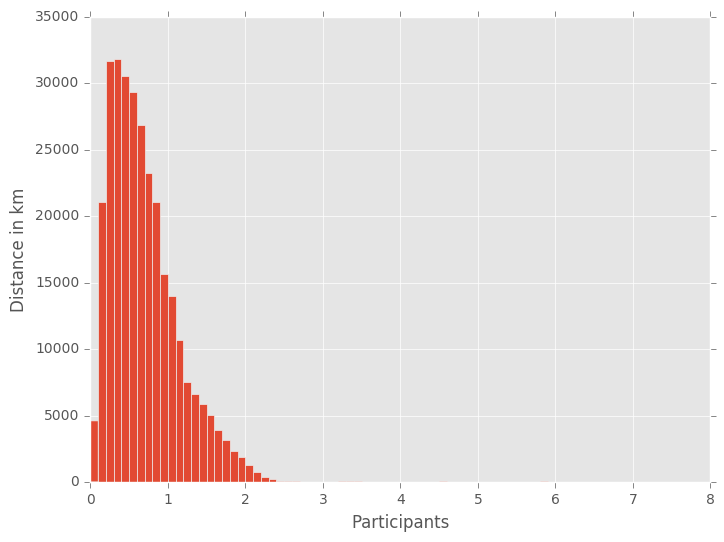

In [10]:
print(vpclldd_df['directdist'].describe())
vpclldd_df['directdist'].hist(bins=np.arange(0,8,0.1))
plt.xlabel("Participants")
plt.ylabel("Distance in km")
plt.show()

In [11]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

Distribution of participants by their distance to nearest MRT/LRT station. As the histogram shows, the majority live within 1km of their closest station.

In [12]:
stns = vpclldd_df['nearest_stn'].unique()
print(type(stns))
print(stns)
# print(str(len(vpclldd_df['nearest_stn'].unique())) + ' unique stations, out of 184 operational stations(including LRTs).')

<class 'numpy.ndarray'>
['EUNOS MRT STATION' 'KOVAN MRT STATION' 'YIO CHU KANG MRT STATION'
 'BUKIT GOMBAK MRT STATION' 'KEMBANGAN MRT STATION'
 'TANAH MERAH MRT STATION' 'SERANGOON MRT STATION' 'KHATIB MRT STATION'
 'ANG MO KIO MRT STATION' 'ADMIRALTY MRT STATION' 'HILLVIEW MRT STATION'
 'WOODLANDS MRT STATION' 'BOON KENG MRT STATION' 'KANGKAR LRT STATION'
 'YEW TEE MRT STATION' 'YISHUN MRT STATION' 'LAKESIDE MRT STATION'
 'LAYAR LRT STATION' 'PUNGGOL MRT STATION' 'RUMBIA LRT STATION'
 'BAKAU LRT STATION' 'BUKIT PANJANG MRT STATION' 'PASIR RIS MRT STATION'
 'TOA PAYOH MRT STATION' 'BUONA VISTA MRT STATION'
 'TIONG BAHRU MRT STATION' 'CHOA CHU KANG MRT STATION'
 'CALDECOTT MRT STATION' 'COMPASSVALE LRT STATION' 'FAJAR LRT STATION'
 'FERNVALE LRT STATION' 'CHENG LIM LRT STATION' 'PIONEER MRT STATION'
 'PAYA LEBAR MRT STATION' 'MERIDIAN LRT STATION' 'HOUGANG MRT STATION'
 'REDHILL MRT STATION' 'TAMPINES MRT STATION' 'CASHEW MRT STATION'
 'MARYMOUNT MRT STATION' 'FARRER PARK MRT STATION'


134 unique stations, out of 183 operational stations(including LRTs), were represented. 

Before I look more closely at the distribution over stations, let's break down the participants into the three categories: less than 400m from nearest MRT station, more than 1km away, and those in between. To do that, let's first take a look at the MRT stations in question.

In [13]:
mrt_df = pd.read_csv(mrt_file)

183


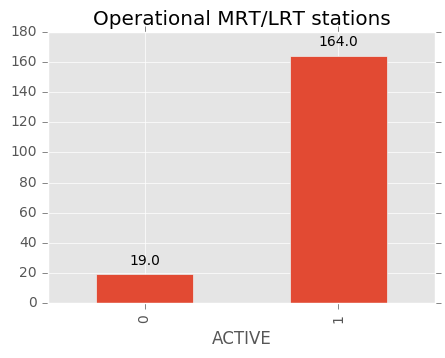

In [14]:
print(len(mrt_df))
ax = mrt_df['ACTIVE'].groupby([mrt_df['ACTIVE']]).count().sort_values().plot(kind='bar', figsize=(5,3.5), title='Operational MRT/LRT stations')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

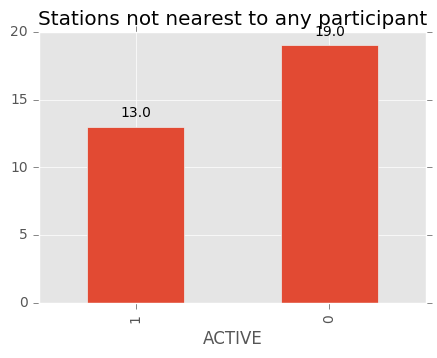

In [15]:
inverse_stns = mrt_df[~mrt_df.STN_NAME.isin(stns)]
# print(len(inverse_stns))
# print(inverse_stns.loc[inverse_stns['ACTIVE'] == 1])
ax = inverse_stns['ACTIVE'].groupby([inverse_stns['ACTIVE']]).count().sort_values().plot(kind='bar', figsize=(5,3.5), title='Stations not nearest to any participant')
for p in ax.patches:
    ax.annotate(np.round(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

The 19 non-operational MRT stations(upcoming downtown line stations, mostly) were not used to calculate the nearest MRT station to participants.

Apart from those 19, we can see that there are 13 operational stations besides, which were not the nearest MRT/LRT station to any of the participants:

In [16]:
print(inverse_stns['STN_NAME'].loc[inverse_stns['ACTIVE'] == 1])

42               SAM KEE LRT STATION
74              TECK LEE LRT STATION
92          HARBOURFRONT MRT STATION
93             PROMENADE MRT STATION
98         TANJONG PAGAR MRT STATION
106             BAYFRONT MRT STATION
114             DOWNTOWN MRT STATION
119           MARINA BAY MRT STATION
120           MARINA BAY MRT STATION
141    MARINA SOUTH PIER MRT STATION
175            PROMENADE MRT STATION
177        RAFFLES PLACE MRT STATION
181           TELOK AYER MRT STATION
Name: STN_NAME, dtype: object


Unsurprisingly, they are mostly in the downtown area.

Now, let's categorize the participants according to their distance from their nearest station.

In [17]:
def dist_bin(dist):
    if dist < 0.4:
        return '< 0.4'
    elif dist > 1.0:
        return '> 1.0'
    else:
        return '0.4 - 1.0'

In [18]:
vpclldd_df['distbin'] = vpclldd_df['directdist'].apply(lambda x: dist_bin(x))
vpclldd_df.head(20)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


EncNRIC postalcode nric_isnull   homelat     homelon  \
0   +++dRFewDCP35Ewg/Hxs0A==     400336       False  1.325720  103.901822   
1   ++/KfZFlfVuQNZJvDuDafQ==     546183       False  1.362425  103.876521   
2   ++08DjepMTLJ7yMy6b8tOg==     578345       False  1.374031  103.832481   
3   ++0kjCLiS480sqIsQ/3GwA==     650420       False  1.362550  103.745771   
4   ++0znnPR1z8lmQnhF2Sfpg==     460059       False  1.324544  103.920616   
6   ++2O1MJu2/uGAYpnA6IXBA==     466507       False  1.315781  103.941424   
7   ++2b52HGYQoZWfUx5UARJA==     357984       False  1.346568  103.868524   
8   ++5VrZG2Zt+rwgJFqv3V3Q==     760776       False  1.422559  103.833944   
9   ++5mkKs7u+tkcSHgaBGIZQ==     560129       False  1.369895  103.842059   
10  ++8m2GXucH+pHlYEHpoXSw==     732685       False  1.441333  103.806136   
11  ++8sSVLMf1+NfCO7yQkO3g==     669558       False  1.362494  103.765891   
12  ++9LeJSHRV9kYw2V4GtrKg==     737785       False  1.428678  103.786351   
13  ++9PVXKzU2pcu4GY+Pc/GQ==     330004       False  1.316205  103.860021   
14  ++9VtS3ZO7yowXl5a5Iakw==     531470       False  1.379055  103.901928   
15  ++9zWrp73kWJ5AkyxUMvPQ==     684686       False  1.404144  103.748356   
16  ++AUajbApEYfCKctu8Y8cw==     760150       False  1.430969  103.833649   
17  ++Bsi82Yg6ABh6wEjKHy2g==     640489       False  1.349175  103.727240   
18  ++ClrSQWcLaUYTVbqw76iA==     798595       False  1.387623  103.879315   
19  ++CtzbW94oP22YF3mDUH7w==     828785       False  1.405036  103.900044   
20  ++EJ2VSbJdWzeWFVI+eBUQ==     540142       False  1.390454  103.905103   

                 nearest_stn   stn_lat     stn_lon  directdist  \
0          EUNOS MRT STATION  1.319779  103.903252       0.679   
1          KOVAN MRT STATION  1.360179  103.885065       0.981   
2   YIO CHU KANG MRT STATION  1.381756  103.844947       1.629   
3   BUKIT GOMBAK MRT STATION  1.358762  103.751894       0.800   
4      KEMBANGAN MRT STATION  1.321038  103.912949       0.937   
6    TANAH MERAH MRT STATION  1.327187  103.946346       1.380   
7      SERANGOON MRT STATION  1.350595  103.872368       0.619   
8         KHATIB MRT STATION  1.417383  103.832980       0.585   
9     ANG MO KIO MRT STATION  1.369933  103.849558       0.833   
10     ADMIRALTY MRT STATION  1.440585  103.800988       0.578   
11      HILLVIEW MRT STATION  1.362345  103.767418       0.170   
12     WOODLANDS MRT STATION  1.436067  103.787931       0.840   
13     BOON KENG MRT STATION  1.319396  103.861687       0.400   
14       KANGKAR LRT STATION  1.383979  103.902174       0.548   
15       YEW TEE MRT STATION  1.397535  103.747405       0.742   
16        YISHUN MRT STATION  1.429443  103.835005       0.227   
17      LAKESIDE MRT STATION  1.344259  103.720949       0.887   
18         LAYAR LRT STATION  1.392080  103.880030       0.502   
19       PUNGGOL MRT STATION  1.404547  103.902073       0.232   
20        RUMBIA LRT STATION  1.391468  103.905974       0.149   

   geocoding_failed latlon_isnull    distbin  
0             False         False  0.4 - 1.0  
1             False         False  0.4 - 1.0  
2             False         False      > 1.0  
3             False         False  0.4 - 1.0  
4             False         False  0.4 - 1.0  
6             False         False      > 1.0  
7             False         False  0.4 - 1.0  
8             False         False  0.4 - 1.0  
9             False         False  0.4 - 1.0  
10            False         False  0.4 - 1.0  
11            False         False      < 0.4  
12            False         False  0.4 - 1.0  
13            False         False  0.4 - 1.0  
14            False         False  0.4 - 1.0  
15            False         False  0.4 - 1.0  
16            False         False      < 0.4  
17            False         False  0.4 - 1.0  
18            False         False  0.4 - 1.0  
19            False         False      < 0.4  
20            False         False      < 0.4

Now it's time to group the participants to see which stations they're closest to.

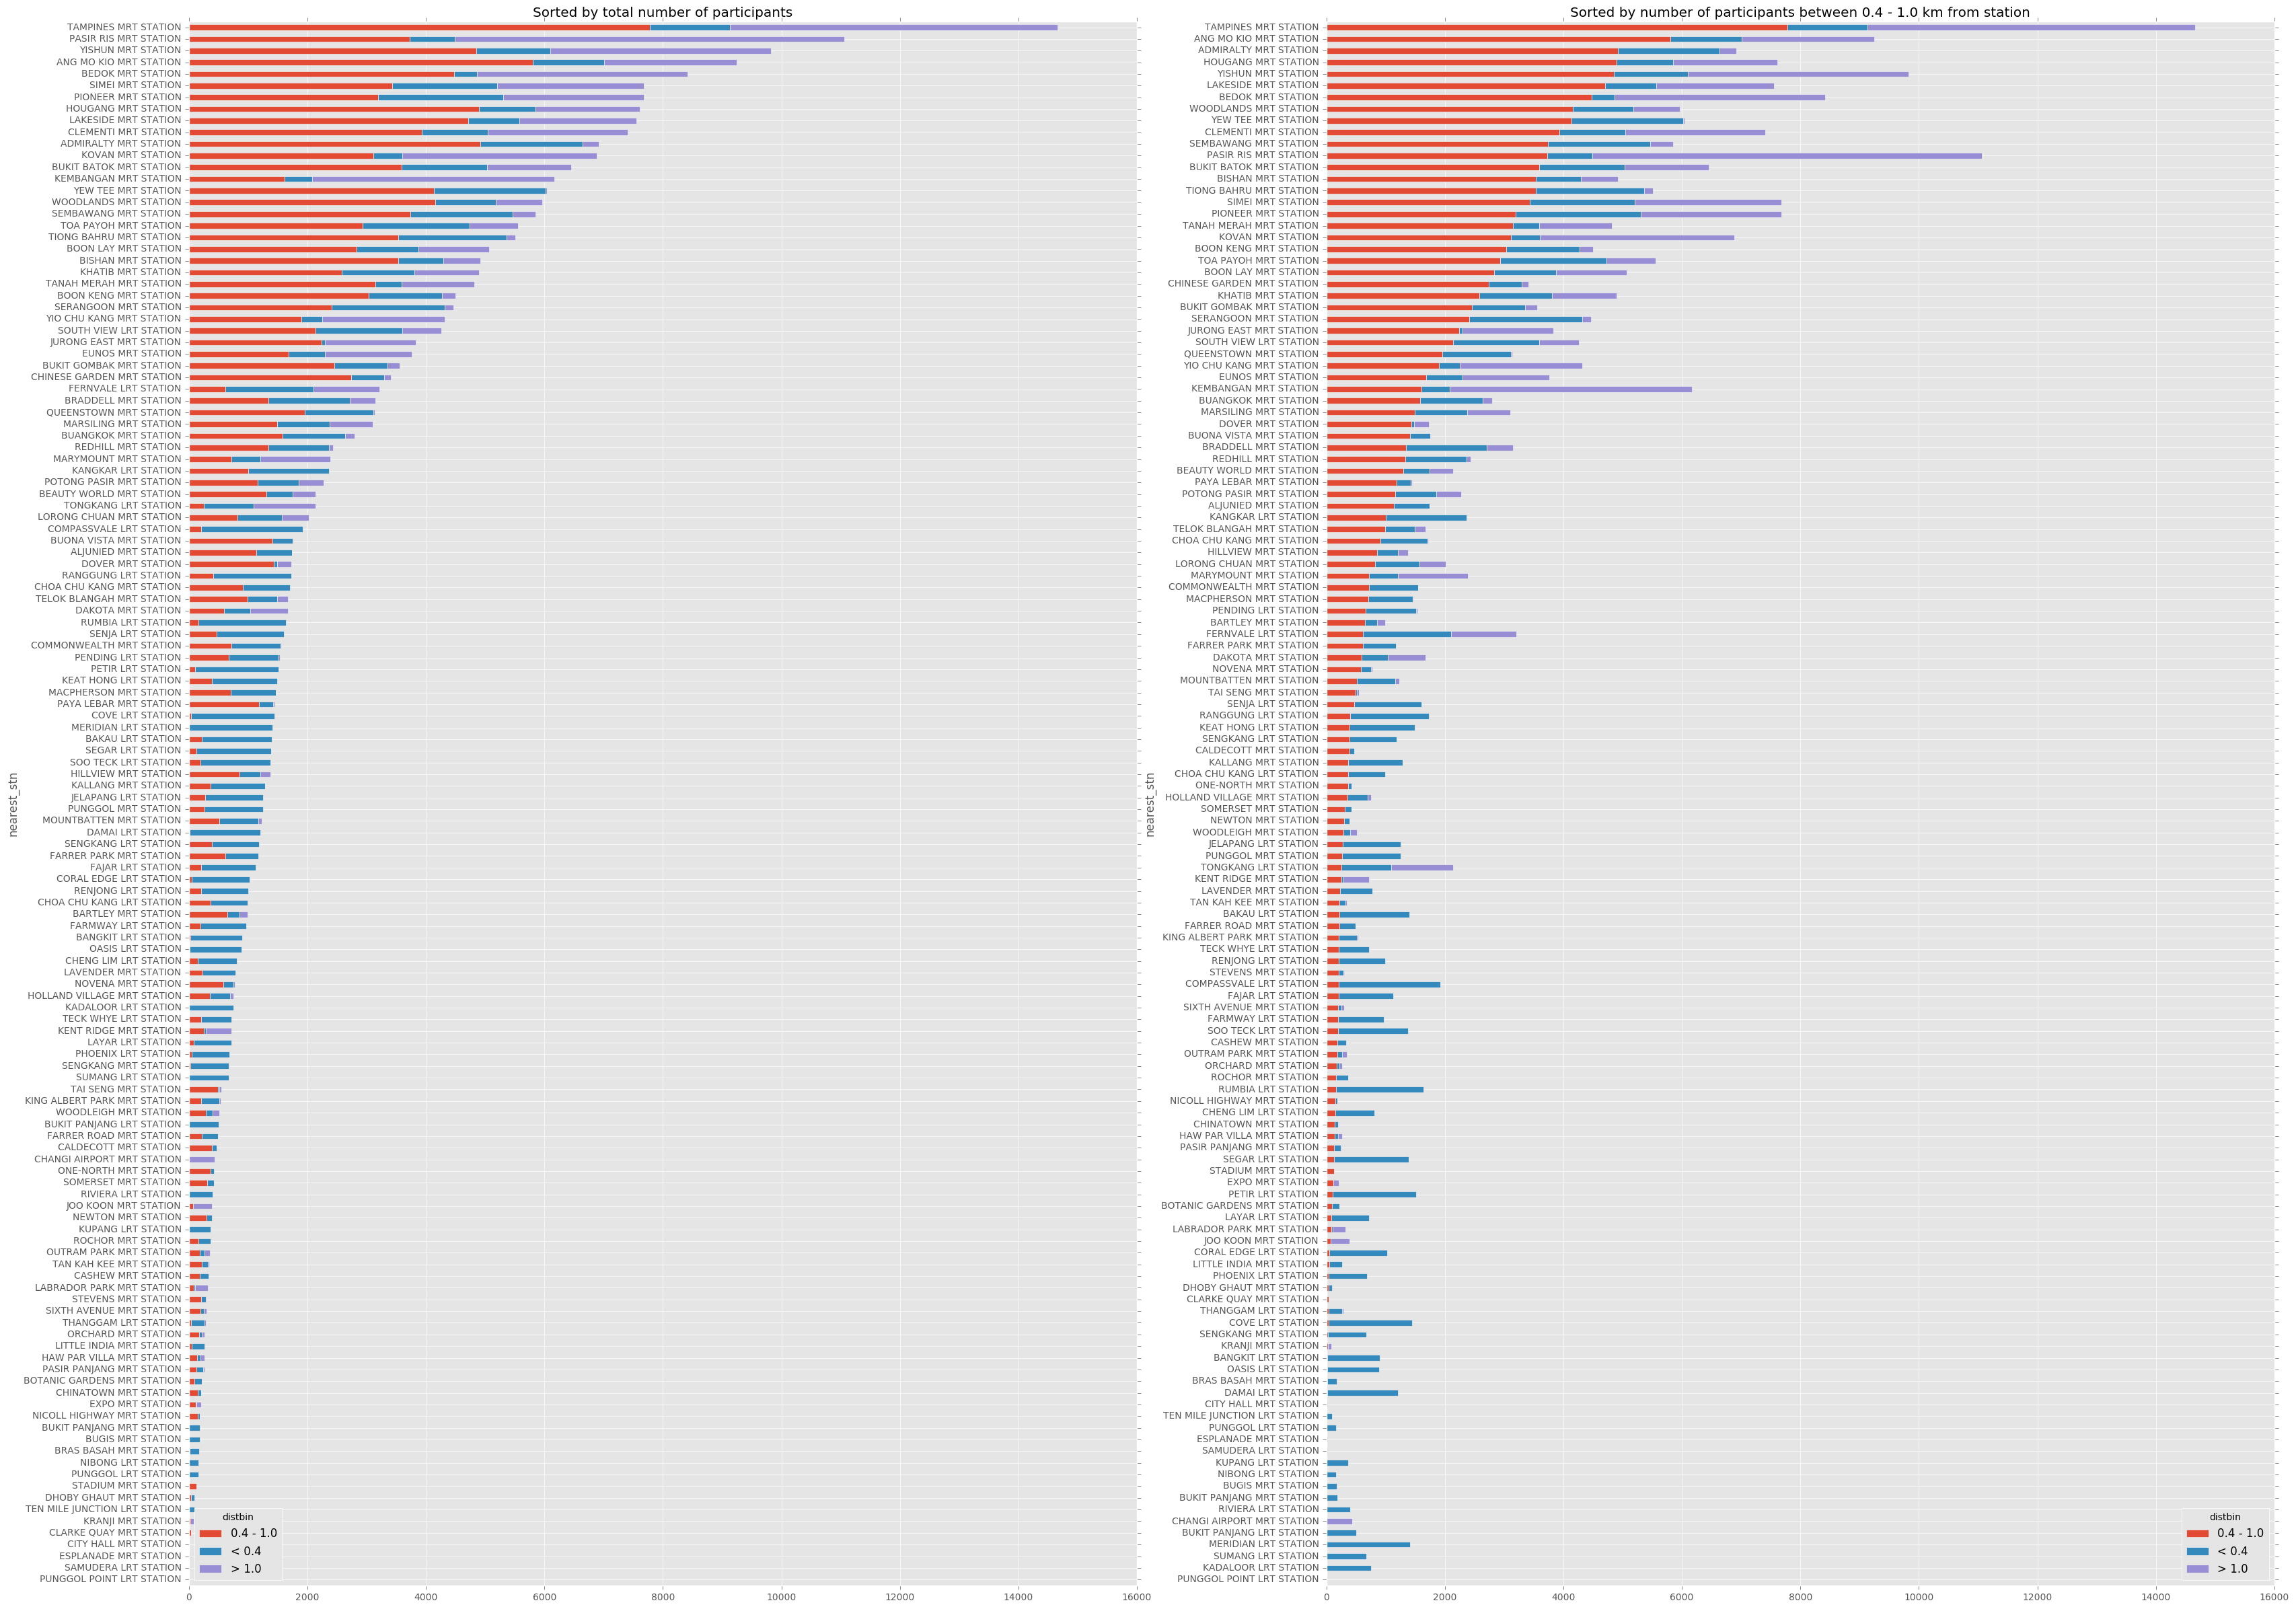

In [19]:
fig, axs = plt.subplots(1,2)

#sorted by total number of participants
stn_by_total_count_df = vpclldd_df.groupby(['nearest_stn'])['nearest_stn'].count().sort_values(ascending=True)

stn_by_dist_df = vpclldd_df.groupby(['nearest_stn', 'distbin'])['nearest_stn'].count().sort_values(ascending=True)
stackstn_by_dist_df = stn_by_dist_df.unstack('distbin').fillna(0).reindex(index=stn_by_total_count_df.index)
stackstn_by_dist_df.plot(kind='barh', stacked=True, figsize=(40,30), ax=axs[0])
axs[0].title.set_text('Sorted by total number of participants')

stackstn_by_intermediate_dist_df  = stackstn_by_dist_df.sort_values(by='0.4 - 1.0', ascending=True)
stackstn_by_intermediate_dist_df.plot(kind='barh', stacked=True, figsize=(40,30), ax=axs[1])
axs[1].title.set_text('Sorted by number of participants between 0.4 - 1.0 km from station')

plt.show()

Bar chart showing participant count by their nearest mrt station. Right click and open image in a new tab to see it in full size. 

The chart on the left is sorted by total number of participants near each station, while the one on the right is sorted by the number of participants between 0.4 - 1.0 km from their nearest station, as represented by the red secment of the stacked bars. 

Slicing and sorting the data in a more readable way would be more easily accomplished in a tool like Tableau, so I'll leave this analysis at this point.

We can map something similar to these two graphs to understand which areas have greater potential for increased participation. First, we'd plot the participants with distance to MRT/LRT station between 0.4 - 1.0 km by geographic region, then divide that by the census data for that region to get a sense of the proportion of residents who participate in NSC2. In order to do this, it's important to select geographical boundaries for which we have census data.

In [20]:
geocensus_file = os.path.join(os.pardir, "data", "MTI_census_2016.geojson")

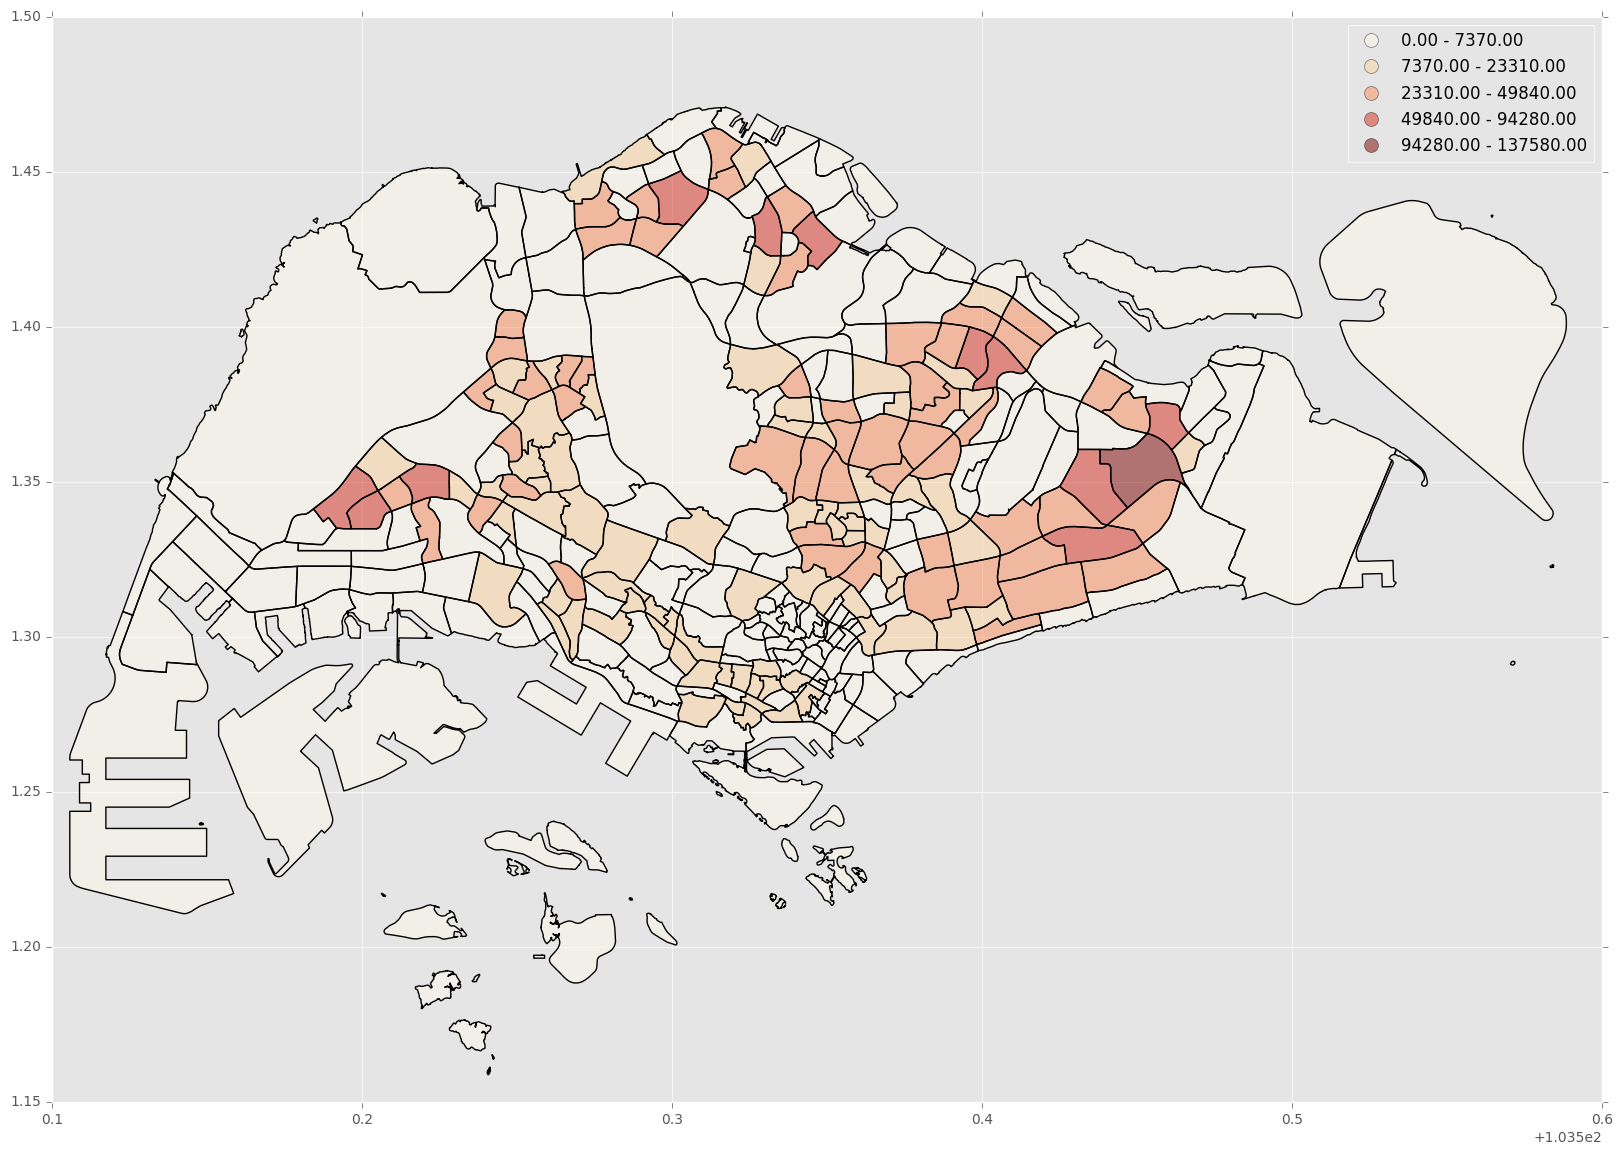

In [21]:
geocensus_gdf = gpd.read_file(geocensus_file)
ax = geocensus_gdf.plot(column="TOTAL", cmap='OrRd', figsize=(20,14), scheme='Fisher_Jenks', legend=True)
fig = plt.show()

This is a basic heat map of Singapore's residential population, based on the Ministry of Trade and Industry's 2016 census data. We can see immediately that the Tampines/Pasir Ris region is much more heavily populated than the rest of the island.

In [22]:
parti_geometry = [Point(xy) for xy in zip(vpclldd_df.homelon, vpclldd_df.homelat)]
parti_gdf = gpd.GeoDataFrame(vpclldd_df, crs={'init': 'epsg:4326'}, geometry=parti_geometry)
wparti_gdf = parti_gdf[['EncNRIC', 'distbin', 'geometry']]
wparti_gdf

EncNRIC    distbin                         geometry
0       +++dRFewDCP35Ewg/Hxs0A==  0.4 - 1.0  POINT (103.9018224 1.325720203)
1       ++/KfZFlfVuQNZJvDuDafQ==  0.4 - 1.0  POINT (103.8765208 1.362425051)
2       ++08DjepMTLJ7yMy6b8tOg==      > 1.0  POINT (103.8324805 1.374031357)
3       ++0kjCLiS480sqIsQ/3GwA==  0.4 - 1.0   POINT (103.7457708 1.36255043)
4       ++0znnPR1z8lmQnhF2Sfpg==  0.4 - 1.0  POINT (103.9206161 1.324544162)
6       ++2O1MJu2/uGAYpnA6IXBA==      > 1.0  POINT (103.9414245 1.315781481)
7       ++2b52HGYQoZWfUx5UARJA==  0.4 - 1.0  POINT (103.8685241 1.346568182)
8       ++5VrZG2Zt+rwgJFqv3V3Q==  0.4 - 1.0  POINT (103.8339441 1.422559348)
9       ++5mkKs7u+tkcSHgaBGIZQ==  0.4 - 1.0  POINT (103.8420591 1.369894989)
10      ++8m2GXucH+pHlYEHpoXSw==  0.4 - 1.0  POINT (103.8061362 1.441333428)
11      ++8sSVLMf1+NfCO7yQkO3g==      < 0.4  POINT (103.7658912 1.362493665)
12      ++9LeJSHRV9kYw2V4GtrKg==  0.4 - 1.0  POINT (103.7863511 1.428677674)
13      ++9PVXKzU2pcu4GY+Pc/GQ==  0.4 - 1.0  POINT (103.8600212 1.316205228)
14      ++9VtS3ZO7yowXl5a5Iakw==  0.4 - 1.0    POINT (103.9019278 1.3790548)
15      ++9zWrp73kWJ5AkyxUMvPQ==  0.4 - 1.0  POINT (103.7483557 1.404143694)
16      ++AUajbApEYfCKctu8Y8cw==      < 0.4  POINT (103.8336487 1.430969418)
17      ++Bsi82Yg6ABh6wEjKHy2g==  0.4 - 1.0  POINT (103.7272398 1.349174596)
18      ++ClrSQWcLaUYTVbqw76iA==  0.4 - 1.0  POINT (103.8793149 1.387623497)
19      ++CtzbW94oP22YF3mDUH7w==      < 0.4   POINT (103.9000438 1.40503555)
20      ++EJ2VSbJdWzeWFVI+eBUQ==      < 0.4  POINT (103.9051029 1.390454154)
21      ++EUvaXXhCOABr/fLdRhyg==      < 0.4  POINT (103.9027208 1.388096407)
22      ++FeAgN+I36UTmiGJMlHNQ==      < 0.4   POINT (103.8729682 1.34718613)
23      ++GoFUfQj2b90xvS8Xpk5A==      < 0.4  POINT (103.7630483 1.379963836)
24      ++I12rLI8tpYu2e3KZVvlA==      > 1.0   POINT (103.938578 1.381761718)
25      ++IBue/eu2lw6YcVwJxp9Q==      < 0.4  POINT (103.8335943 1.419197045)
26      ++ID6s05fVu2RKD/LxPU0Q==      < 0.4   POINT (103.849823 1.334727136)
28      ++J/vHEWj0GZbooJtKENJg==  0.4 - 1.0  POINT (103.7926014 1.309983984)
29      ++JEzzhqtZAbxvkKHWkJng==      < 0.4  POINT (103.8457238 1.333570575)
30      ++JiS0xlCXsfRDOFNqaLgA==  0.4 - 1.0  POINT (103.8310493 1.284670567)
32      ++N9czw5AVY0yBer0jnoYA==  0.4 - 1.0   POINT (103.7856751 1.30831872)
...                          ...        ...                              ...
339089  zzcJD2qHiBTMuI356TSJpQ==      < 0.4   POINT (103.7424242 1.38584605)
339090  zzcmur7NW3WfGAsLC5hkFg==  0.4 - 1.0  POINT (103.8598605 1.327607041)
339091  zzeIuPEj5VOkJkxsdKdPoA==      < 0.4  POINT (103.6958398 1.340369897)
339092  zzeS+VYqeMu1aGZ4rqRaeQ==  0.4 - 1.0  POINT (103.7045422 1.341961793)
339093  zzfTMo7v6KRGZrVF1bz7Dw==  0.4 - 1.0  POINT (103.8226125 1.282774432)
339094  zzfceoJloV2sWrIc+bV0TA==      < 0.4  POINT (103.7994173 1.300727923)
339095  zzfx4Y/Tc/++jc0+xrQeUA==  0.4 - 1.0  POINT (103.7821881 1.304915957)
339096  zzgiKGFsauO0TKNPE+YWog==  0.4 - 1.0  POINT (103.7300291 1.350554953)
339098  zzhGBFGS3Na+mfocXjbCwA==      > 1.0  POINT (103.8342845 1.369946401)
339099  zzi986HT+Uu8sQ3wqAwpTg==  0.4 - 1.0  POINT (103.7539799 1.352221043)
339100  zzl8r2z2JVbpSFfVv5eBZw==      > 1.0  POINT (103.8463817 1.432626083)
339101  zzlEYXtGuqvXSiyshAKt5w==  0.4 - 1.0  POINT (103.8716516 1.315431758)
339102  zzlyZifHqOxN/LWd9yllyQ==      > 1.0  POINT (103.9291912 1.350926367)
339103  zzmTP3n7OfVFvpRUdyLGUg==  0.4 - 1.0  POINT (103.8962745 1.377762881)
339104  zzmj97M3MYS1EFE2/ecVmg==      > 1.0  POINT (103.7717205 1.444983463)
339105  zzq4XdMFjYSyjkP+vHIZAw==      > 1.0  POINT (103.6920181 1.345708272)
339106  zzqrTyoNCOfx62ZjbJHfyQ==  0.4 - 1.0  POINT (103.7509933 1.403187013)
339107  zzr0JjU7qeYOkqhOtyl1+g==  0.4 - 1.0   POINT (103.8424103 1.38436749)
339108  zzrTLeXRFb78FeQGw1oppQ==      < 0.4     POINT (103.77027 1.38987347)
339109  zzre5Sj2lxOSz+78pnhqWw==  0.4 - 1.0  POINT (103.7150977 1.344390406)
339110  zzt1FrninFN+K

Here we've converted the (valid postal codes + latlons + directdist) of participants into a geopandas dataframe, so that it can interact with the geopandas dataframe containing the census data, in what we call a spatial join. We'll also pull out just the distance bin category for each participant into a geodataframe for us to work with. I'm also going to do something similar to the geocensus GeoPandas DataFrame in the cell below.

In [23]:
geocensus_gdf = geocensus_gdf[['PLN_AREA_N', 'SUBZONE_N', 'TOTAL', 'geometry']]
geocensus_gdf

PLN_AREA_N                 SUBZONE_N    TOTAL  \
0                     OUTRAM             PEOPLE'S PARK    330.0   
1                BUKIT MERAH               BUKIT MERAH   1150.0   
2                     OUTRAM                 CHINATOWN  11550.0   
3              DOWNTOWN CORE                   PHILLIP      0.0   
4              DOWNTOWN CORE             RAFFLES PLACE     60.0   
5                     OUTRAM              CHINA SQUARE   1530.0   
6                BUKIT MERAH               TIONG BAHRU  12830.0   
7              DOWNTOWN CORE          BAYFRONT SUBZONE      0.0   
8                BUKIT MERAH       TIONG BAHRU STATION  16340.0   
9              DOWNTOWN CORE             CLIFFORD PIER      0.0   
10              MARINA SOUTH              MARINA SOUTH      0.0   
11                    OUTRAM              PEARL'S HILL   8030.0   
12           SINGAPORE RIVER                 BOAT QUAY    150.0   
13               BUKIT MERAH            HENDERSON HILL  12240.0   
14               BUKIT MERAH                   REDHILL  12060.0   
15               BUKIT MERAH            ALEXANDRA HILL  15360.0   
16               BUKIT MERAH             BUKIT HO SWEE  16040.0   
17           SINGAPORE RIVER               CLARKE QUAY    120.0   
18               BUKIT MERAH        TELOK BLANGAH RISE  13530.0   
19             DOWNTOWN CORE             TANJONG PAGAR    550.0   
20               BUKIT MERAH              EVERTON PARK   9050.0   
21               BUKIT MERAH         TELOK BLANGAH WAY  10500.0   
22             DOWNTOWN CORE                   MAXWELL      0.0   
23             DOWNTOWN CORE                     CECIL    180.0   
24               BUKIT MERAH       KAMPONG TIONG BAHRU  10270.0   
25               BUKIT MERAH       TELOK BLANGAH DRIVE  16030.0   
26                QUEENSTOWN           PASIR PANJANG 2   3430.0   
27                QUEENSTOWN           PASIR PANJANG 1   4090.0   
28           WESTERN ISLANDS                   SEMAKAU      0.0   
29          SOUTHERN ISLANDS            SOUTHERN GROUP      0.0   
..                       ...                       ...      ...   
293                   YISHUN            YISHUN CENTRAL   1460.0   
294                  SELETAR       PULAU PUNGGOL TIMOR      0.0   
295             SUNGEI KADUT                 TURF CLUB    670.0   
296                WOODLANDS           WOODLANDS SOUTH  36450.0   
297                WOODLANDS                 WOODGROVE  35930.0   
298                   YISHUN               YISHUN EAST  56750.0   
299  WESTERN WATER CATCHMENT   WESTERN WATER CATCHMENT    800.0   
300                SEMBAWANG                 ADMIRALTY  14510.0   
301             LIM CHU KANG              LIM CHU KANG    100.0   
302                  SIMPANG             SIMPANG NORTH      0.0   
303                SEMBAWANG              SENOKO SOUTH     20.0   
304                SEMBAWANG           SEMBAWANG NORTH  27110.0   
305                  SIMPANG              TANJONG IRAU      0.0   
306             SUNGEI KADUT                  PANG SUA     20.0   
307                  SELETAR    SELETAR AEROSPACE PARK     20.0   
308                   YISHUN                    KHATIB  10600.0   
309                   MANDAI               MANDAI WEST      0.0   
310                  PUNGGOL              CONEY ISLAND      0.0   
311                   YISHUN              YISHUN SOUTH  38180.0   
312                SEMBAWANG               THE WHARVES      0.0   
313                SEMBAWANG              SENOKO NORTH     20.0   
314                SEMBAWANG            SEMBAWANG EAST     90.0   
315                WOODLANDS               SENOKO WEST     20.0   
316                PASIR RIS            PASIR RIS PARK   4850.0   
317            CHOA CHU KANG       CHOA CHU KANG NORTH  33980.0   
318                 SENGKANG                 RIVERVALE  61220.0   
319                PASIR RIS  PASIR RIS WAFER FAB PARK     20.0   
320                  PUNGGOL                   MATILDA  37380.0  

In [24]:
%%time
# the spatial join
zoned_wparti_gdf = gpd.sjoin(geocensus_gdf, wparti_gdf, how="inner", op='intersects')

Wall time: 33.9 s


In [25]:
len(zoned_wparti_gdf)
zoned_wparti_gdf

PLN_AREA_N          SUBZONE_N   TOTAL  \
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
1    BUKIT MERAH        BUKIT MERAH  1150.0   
..           ...                ...     ...   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   
322    SEMBAWANG  SEMBAWANG STRAITS  1750.0   

                                              geometry  index_right  \
1    (POLYGON ((103.8220876771419 1.280494489593267...       300970   
1    (POLYGON ((103.8220876771419 1.280494489593267...       162322   
1    (POLYGON ((103.8220876771419 1.280494489593267...       102853   
1    (POLYGON ((103.8220876771419 1.280494489593267...        69167   
1    (POLYGON ((103.8220876771419 1.280494489593267...       129563   
1    (POLYGON ((103.8220876771419 1.280494489593267...        12222   
1    (POLYGON ((103.8220876771419 1.280494489593267...        80367   
1    (POLYGON ((103.8220876771419 1.280494489593267...        89579   
1    (POLYGON ((103.8220876771419 1.280494489593267...       149238   
1    (POLYGON ((103.8220876771419 1.280494489593267...        52555   
1    (POLYGON ((103.8220876771419 1.280494489593267...       176502   
1    (POLYGON ((103.8220876771419 1.280494489593267...       160156   
1    (POLYGON ((103.8220876771419 1.280494489593267...        48296   
1    (POLYGON ((103.8220876771419 1.280494489593267...         3436   
1    (POLYGON ((103.822087

Now that we have the subzone of every participant, it's just a matter of grouping by the subzone to get a count of participants in each one. From there, we move on to plot the chloropleth map just like we did with the plain census data.

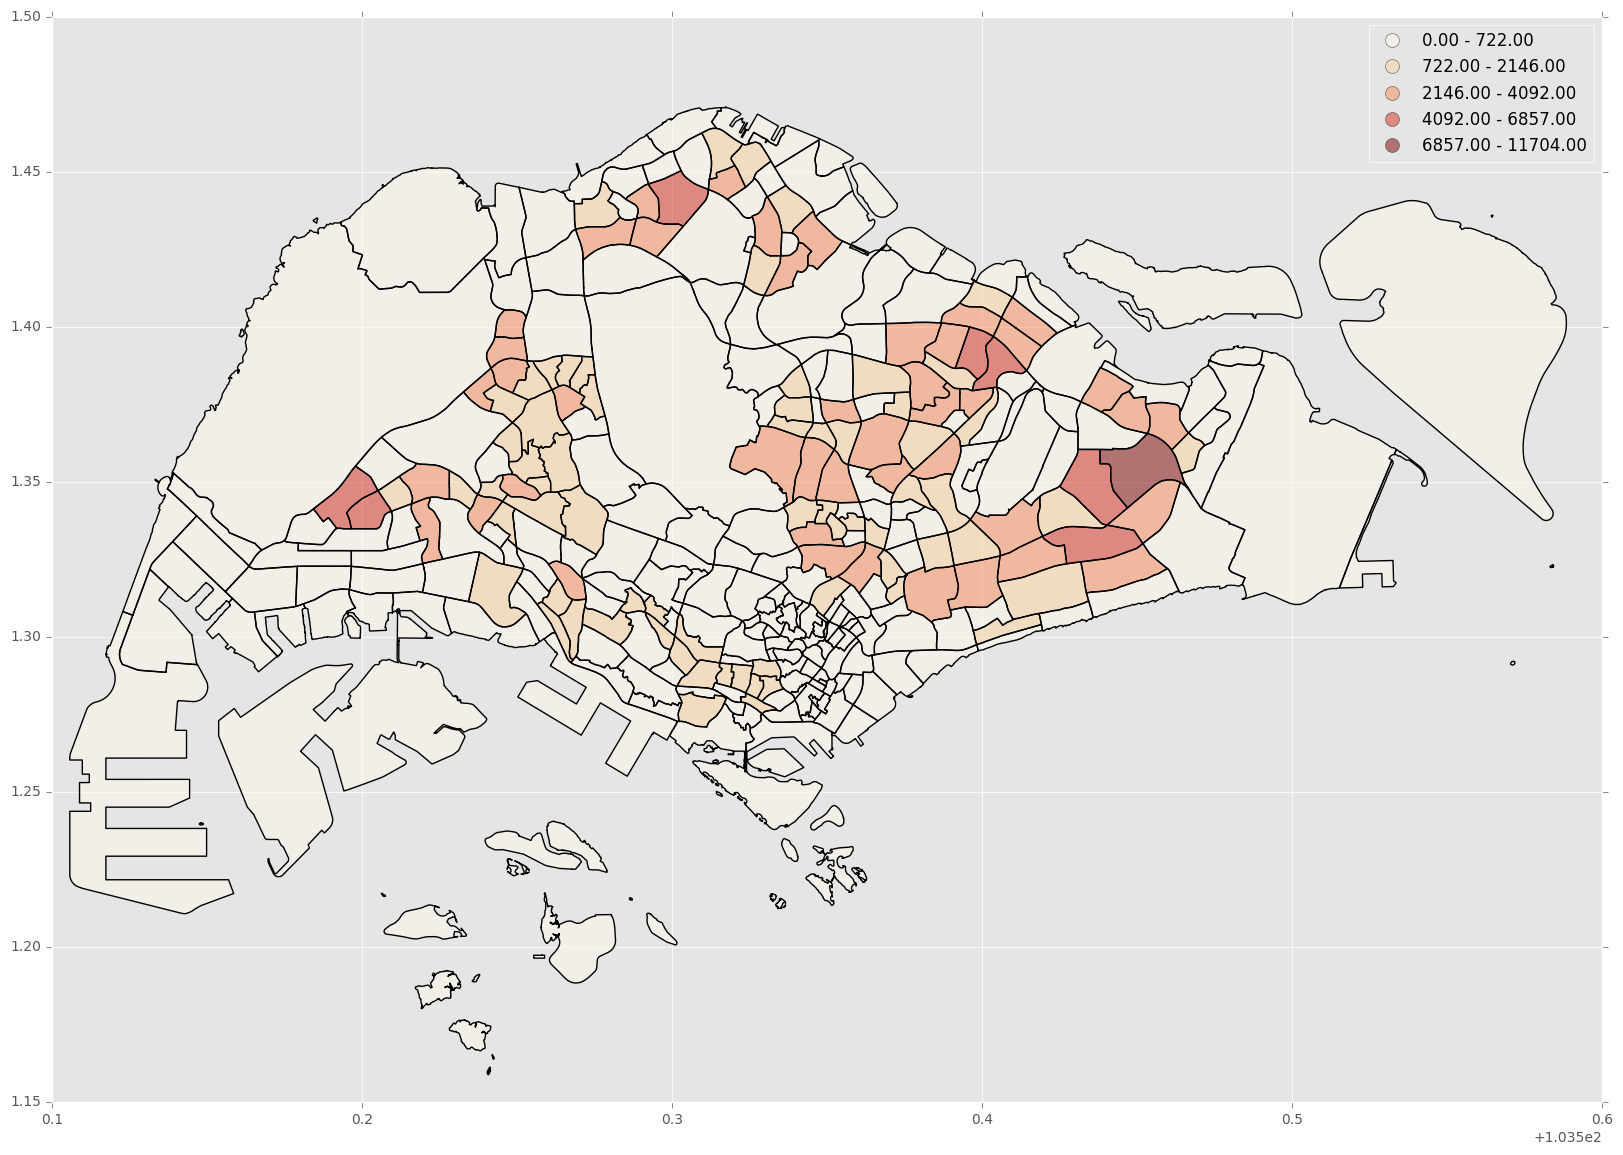

In [26]:
subzone_count_df = zoned_wparti_gdf.groupby(['SUBZONE_N']).count().reset_index()
subzone_count_df = subzone_count_df.iloc[:,:2]
subzone_count_df.rename(columns = {'PLN_AREA_N':'parti_count'}, inplace = True)
subzone_count_df

subzone_count_gdf = pd.merge(geocensus_gdf, subzone_count_df, how='left', on='SUBZONE_N', sort=False).fillna(0)

ax = subzone_count_gdf.plot(column="parti_count", cmap='OrRd', figsize=(20,14), scheme='Fisher_Jenks', legend=True)
fig = plt.show()

Comparing this plot to the census plot, it's not really obvious where we should be targetting yet. All we can see is that participation in NSC2 is more evenly spread out from the dense residential centers than the population. 

Possible reasons could be that people living further from the dense residential centers have more interest in the program, or that the success of public engagement hits a ceiling per geographical area regardless of density.

In [27]:
def parti_ratio(total, parti):
    if total == 0:
        return 0
    else:
        return parti/total

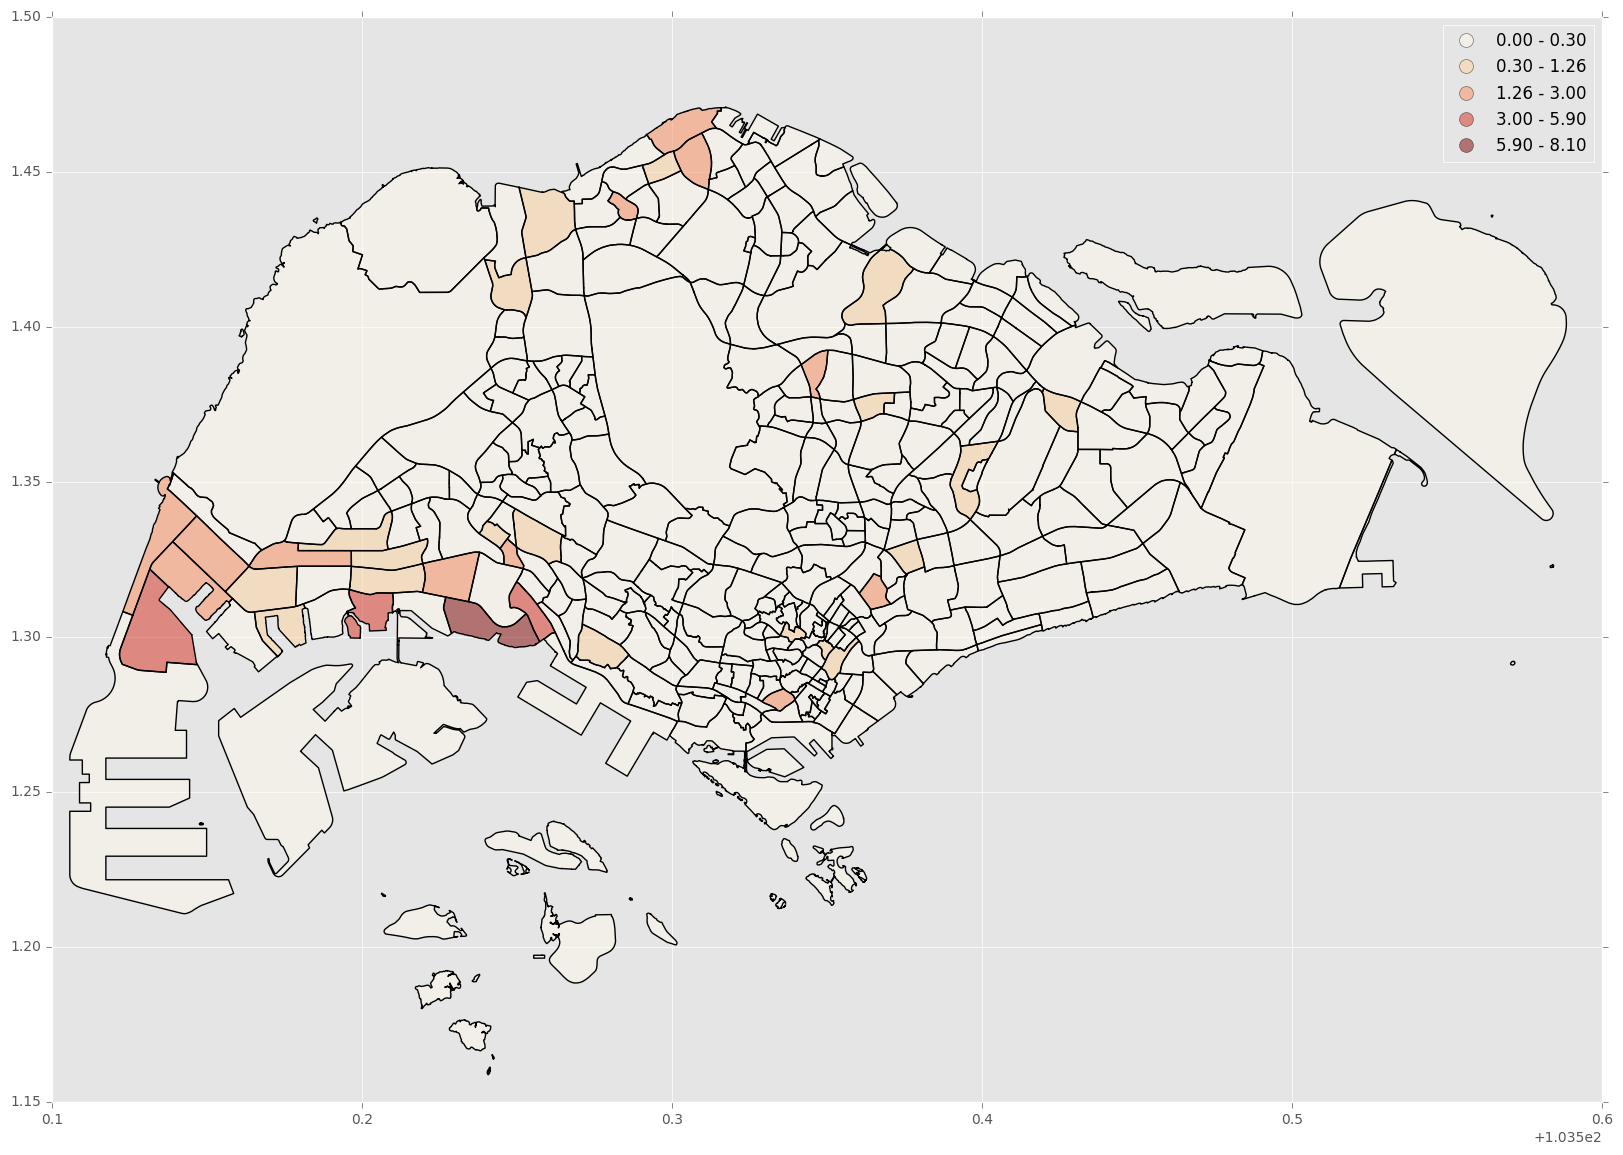

In [28]:
subzone_count_gdf['participation_rate'] = subzone_count_gdf.apply(lambda x: parti_ratio(x['TOTAL'], x['parti_count']), axis=1)

ax = subzone_count_gdf.plot(column="participation_rate", cmap='OrRd', figsize=(20,14), scheme='Fisher_Jenks', legend=True)
fig = plt.show()

Not to be used for analysis, but a quick plot of participant per capita in each subzone

In [29]:
stackstn_by_dist_df

distbin                        0.4 - 1.0   < 0.4   > 1.0
nearest_stn                                             
PUNGGOL POINT LRT STATION            0.0     2.0     0.0
SAMUDERA LRT STATION                 0.0     9.0     0.0
ESPLANADE MRT STATION                0.0    13.0     0.0
CITY HALL MRT STATION                8.0     9.0     0.0
CLARKE QUAY MRT STATION             37.0     2.0     0.0
KRANJI MRT STATION                  20.0     2.0    63.0
TEN MILE JUNCTION LRT STATION        0.0    94.0     0.0
DHOBY GHAUT MRT STATION             38.0    57.0     0.0
STADIUM MRT STATION                124.0     1.0     0.0
PUNGGOL LRT STATION                  0.0   157.0     0.0
NIBONG LRT STATION                   0.0   163.0     0.0
BRAS BASAH MRT STATION              14.0   156.0     0.0
BUGIS MRT STATION                    0.0   178.0     0.0
BUKIT PANJANG MRT STATION            0.0   187.0     0.0
NICOLL HIGHWAY MRT STATION         152.0    32.0     4.0
EXPO MRT STATION                   117.0     4.0    82.0
CHINATOWN MRT STATION              144.0    57.0     4.0
BOTANIC GARDENS MRT STATION         95.0   120.0     1.0
PASIR PANJANG MRT STATION          127.0   117.0    13.0
HAW PAR VILLA MRT STATION          140.0    59.0    60.0
LITTLE INDIA MRT STATION            44.0   216.0     0.0
ORCHARD MRT STATION                175.0    40.0    47.0
THANGGAM LRT STATION                36.0   227.0    23.0
SIXTH AVENUE MRT STATION           199.0    52.0    42.0
STEVENS MRT STATION                208.0    78.0     9.0
LABRADOR PARK MRT STATION           82.0    20.0   220.0
CASHEW MRT STATION                 188.0   147.0     0.0
TAN KAH KEE MRT STATION            221.0   103.0    20.0
OUTRAM PARK MRT STATION            184.0    82.0    82.0
ROCHOR MRT STATION                 164.0   201.0     0.0
...                                  ...     ...     ...
BUKIT GOMBAK MRT STATION          2454.0   899.0   207.0
EUNOS MRT STATION                 1681.0   610.0  1471.0
JURONG EAST MRT STATION           2243.0    56.0  1525.0
SOUTH VIEW LRT STATION            2132.0  1464.0   660.0
YIO CHU KANG MRT STATION          1901.0   349.0  2065.0
SERANGOON MRT STATION             2407.0  1913.0   149.0
BOON KENG MRT STATION             3037.0  1231.0   229.0
TANAH MERAH MRT STATION           3148.0   438.0  1230.0
KHATIB MRT STATION                2583.0  1221.0  1089.0
BISHAN MRT STATION                3538.0   751.0   634.0
BOON LAY MRT STATION              2826.0  1046.0  1198.0
TIONG BAHRU MRT STATION           3533.0  1827.0   154.0
TOA PAYOH MRT STATION             2933.0  1798.0   819.0
SEMBAWANG MRT STATION             3741.0  1718.0   392.0
WOODLANDS MRT STATION             4163.0  1015.0   788.0
YEW TEE MRT STATION               4140.0  1882.0    25.0
KEMBANGAN MRT STATION             1609.0   471.0  4088.0
BUKIT BATOK MRT STATION           3593.0  1438.0  1417.0
KOVAN MRT STATION                 3118.0   488.0  3273.0
ADMIRALTY MRT STATION             4914.0  1725.0   282.0
CLEMENTI MRT STATION              3928.0  1115.0  2366.0
LAKESIDE MRT STATION              4709.0   863.0  1983.0
HOUGANG MRT STATION               4895.0   952.0  1760.0
PIONEER MRT STATION               3190.0  2111.0  2379.0
SIMEI MRT STATION                 3432.0  1766.0  2483.0
BEDOK MRT STATION                 4471.0   390.0  3550.0
ANG MO KIO MRT STATION            5807.0  1205.0  2238.0
YISHUN MRT STATION                4846.0  1257.0  3726.0
PASIR RIS MRT STATION             3728.0   761.0  6575.0
TAMPINES MRT STATION              7775.0  1361.0  5521.0

[134 rows x 3 columns]

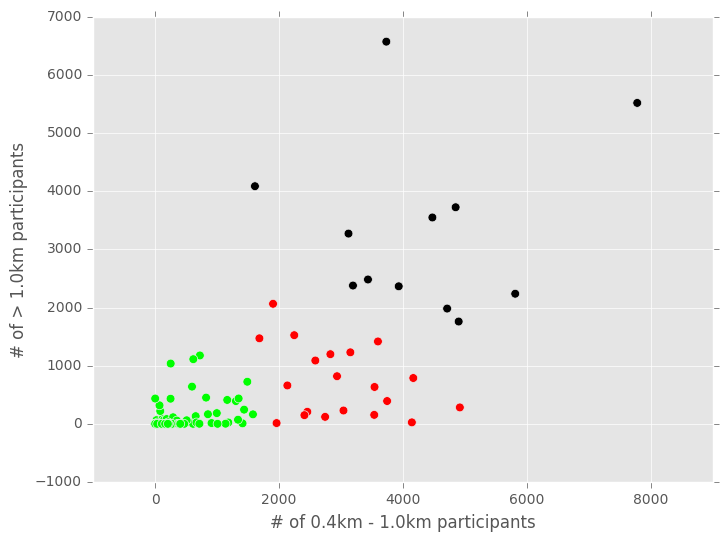

In [30]:
colormap = np.array(['lime', 'black', 'red', 'blue'])

km = KMeans(n_clusters=3)
km.fit(stackstn_by_dist_df)
labels = km.labels_
plt.scatter(stackstn_by_dist_df['0.4 - 1.0'], stackstn_by_dist_df['> 1.0'], c=colormap[km.labels_], s=40)
plt.xlabel('# of 0.4km - 1.0km participants')
plt.ylabel("# of > 1.0km participants")
plt.show()

Initial attempt of k-means cluster by just >1.0km and 0.4 - 1.0km counts, since < 0.4km counts seemed to have less variance than these two

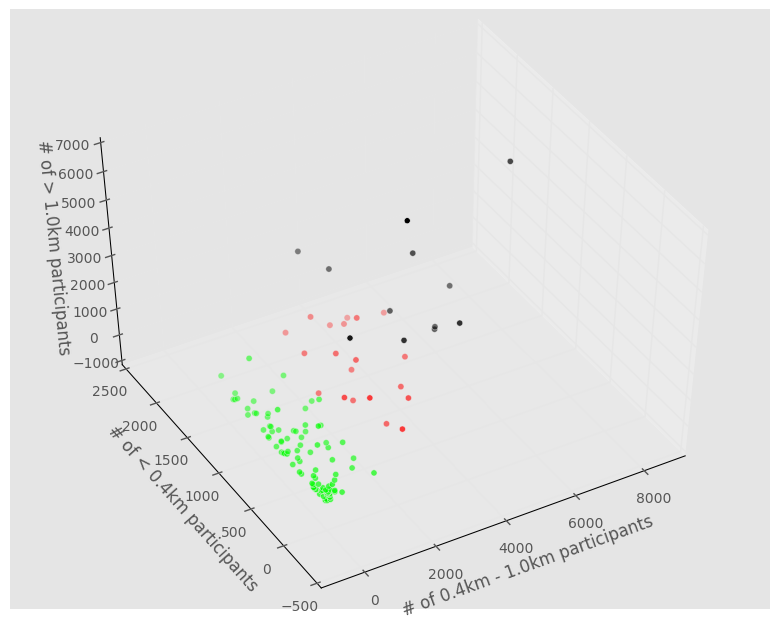

In [31]:
fig = plt.figure(figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=240)
plt.cla()

ax.scatter(stackstn_by_dist_df['0.4 - 1.0'], stackstn_by_dist_df['< 0.4'], stackstn_by_dist_df['> 1.0'], c=colormap[km.labels_])

ax.set_xlabel('# of 0.4km - 1.0km participants')
ax.set_ylabel('# of < 0.4km participants')
ax.set_zlabel('# of > 1.0km participants')

plt.show()

3d plot of the stations by number of participants in each distance bin.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


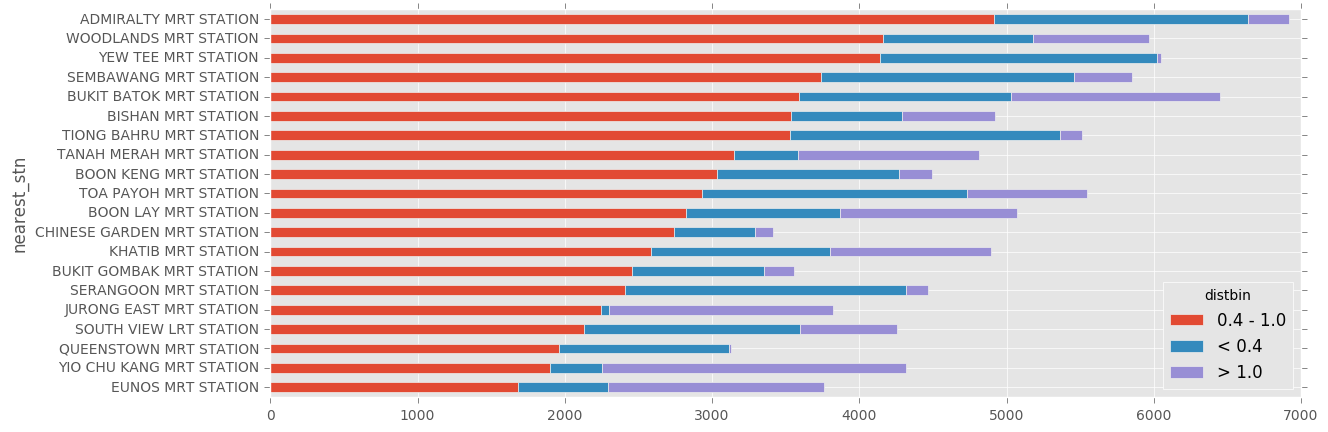

In [32]:
stackstn_by_dist_df['cluster'] = km.labels_
critical_cluster_df = stackstn_by_dist_df.loc[stackstn_by_dist_df['cluster'] == 2]
critical_cluster_df.sort_values(by='0.4 - 1.0', ascending=True, inplace=True)
critical_cluster_df.drop('cluster', axis=1, inplace=True)

critical_cluster_df.plot(kind='barh', stacked=True, figsize=(13.3,5))
# ax.title.set_text('Red Cluster Stations distribution')
plt.show()

20 stations in the intermediate growth cluster

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


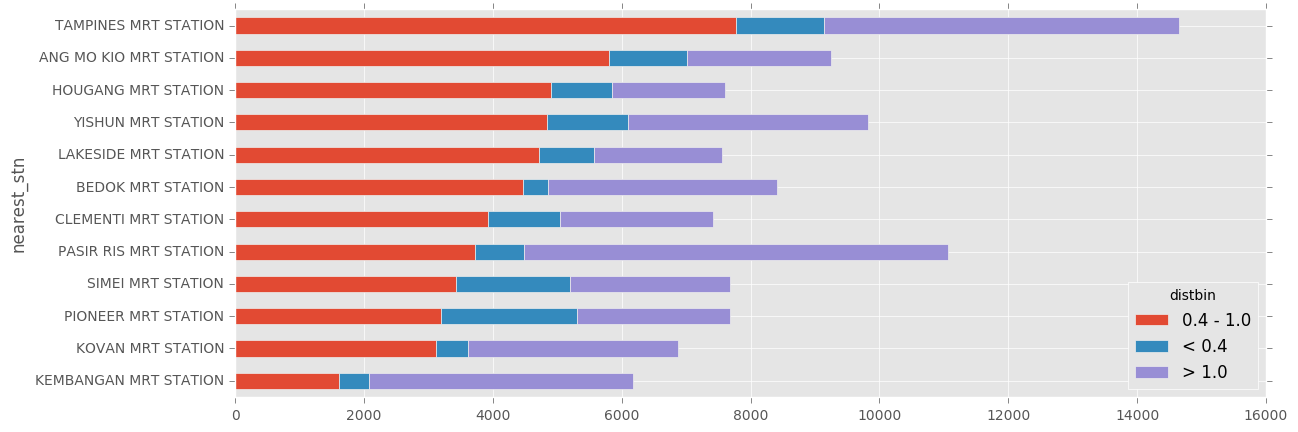

In [33]:
stackstn_by_dist_df['cluster'] = km.labels_
mature_cluster_df = stackstn_by_dist_df.loc[stackstn_by_dist_df['cluster'] == 1]
mature_cluster_df.sort_values(by='0.4 - 1.0', ascending=True, inplace=True)
mature_cluster_df.drop('cluster', axis=1, inplace=True)

mature_cluster_df.plot(kind='barh', stacked=True, figsize=(13.3,5))
# ax.title.set_text('Red Cluster Stations distribution')
plt.show()

12 stations in the mature cluster

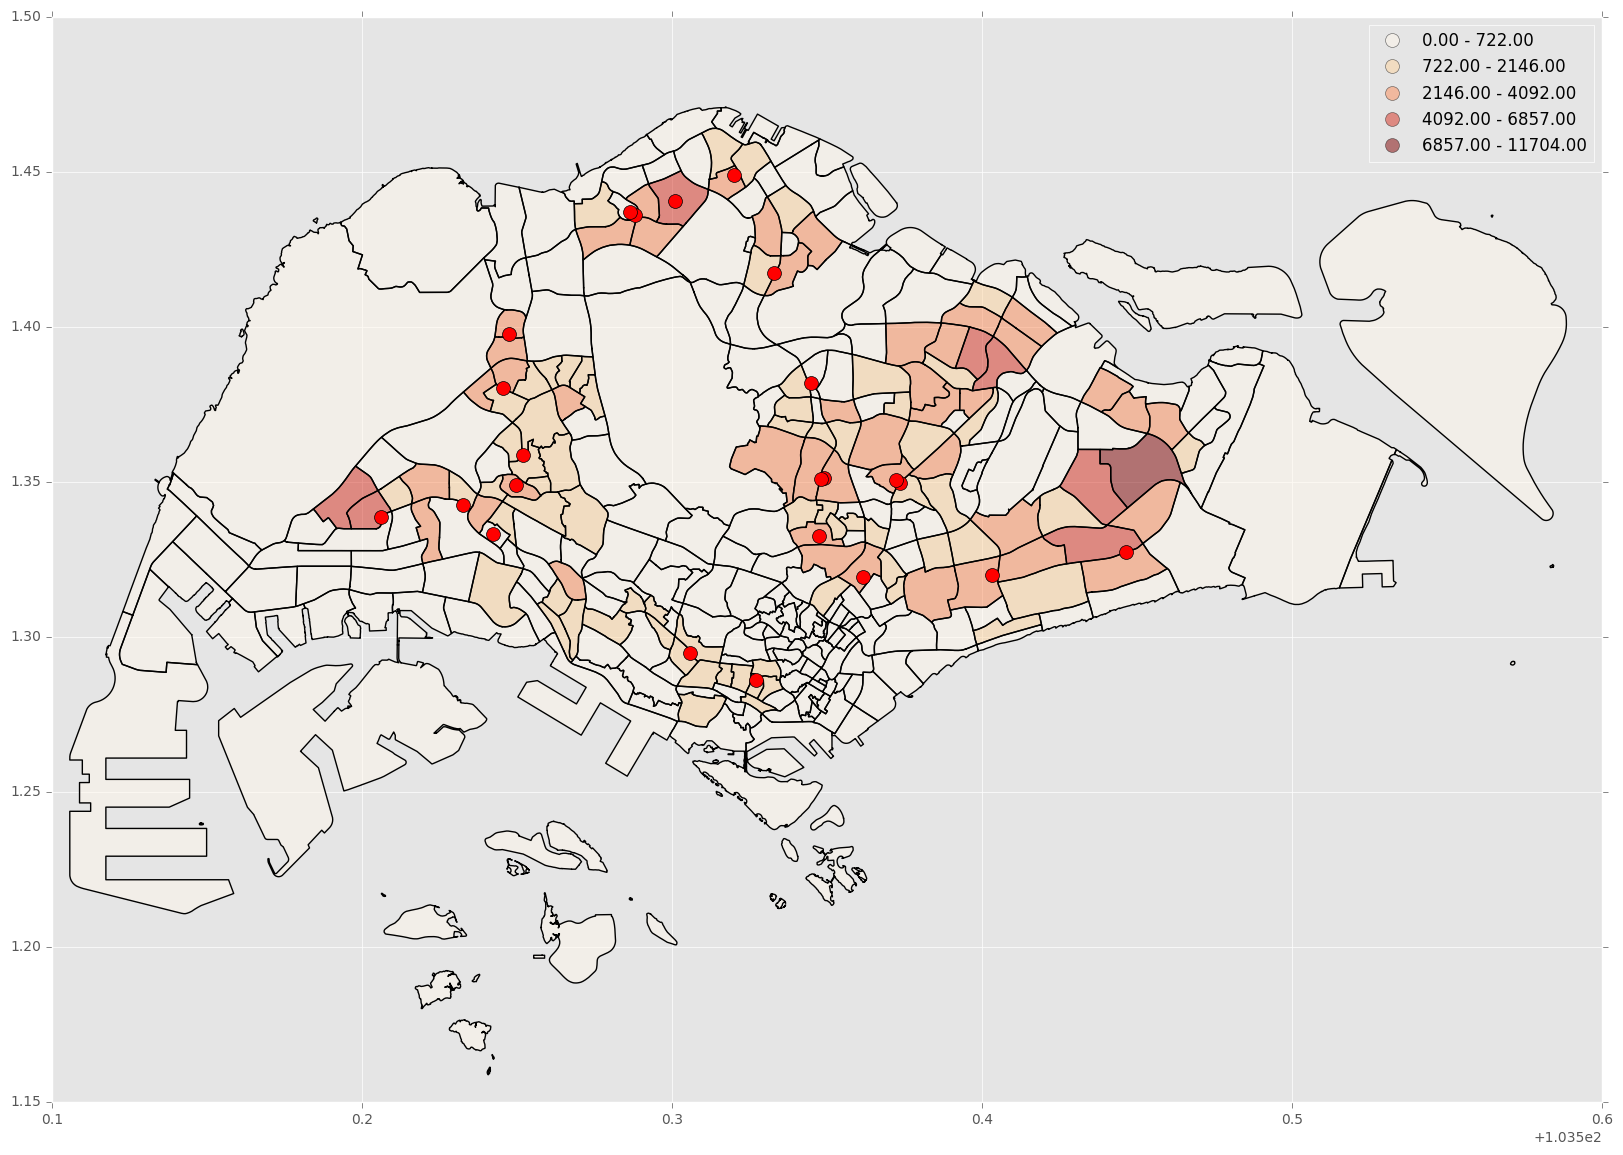

In [34]:
critical_cluster_latlon_df = pd.merge(mrt_df, critical_cluster_df, how='right', right_index=True, left_on='STN_NAME', sort=False)
critical_cluster_latlon_df.sort_values(by='0.4 - 1.0', ascending=True, inplace=True)
critical_cluster_latlon_df
critical_cluster_latlon_df = critical_cluster_latlon_df[['STN_NAME', '0.4 - 1.0', '< 0.4', '> 1.0', 'LATITUDE', 'LONGITUDE']]
critical_cluster_latlon_df.drop_duplicates()
critical_cluster_latlon_df.reset_index(inplace=True, drop=True)

cc_geometry = [Point(xy) for xy in zip(critical_cluster_latlon_df.LONGITUDE, critical_cluster_latlon_df.LATITUDE)]
critical_cluster_latlon_gdf = gpd.GeoDataFrame(critical_cluster_latlon_df, crs={'init': 'epsg:4326'}, geometry=cc_geometry)
critical_cluster_latlon_gdf = critical_cluster_latlon_gdf[['STN_NAME', '0.4 - 1.0', '< 0.4', '> 1.0', 'geometry']]

# base = geocensus_gdf.plot(color='white')
base = subzone_count_gdf.plot(column="parti_count", cmap='OrRd', figsize=(20,14), scheme='Fisher_Jenks', legend=True)
critical_cluster_latlon_gdf.plot(ax= base, marker='o', color='red', markersize=10)
# fig, ax = plt.subplots()
# [ax.plot(row['LONGITUDE'], row['LATITUDE'],'.', row['0.4 - 1.0'], latlon=True) for idx, row in critical_cluster_latlon_gdf.iterrows()]
plt.show()

Overlay of the growth stations over the participation distribution plot.

In [35]:
vpclldd_df

EncNRIC postalcode nric_isnull   homelat     homelon  \
0       +++dRFewDCP35Ewg/Hxs0A==     400336       False  1.325720  103.901822   
1       ++/KfZFlfVuQNZJvDuDafQ==     546183       False  1.362425  103.876521   
2       ++08DjepMTLJ7yMy6b8tOg==     578345       False  1.374031  103.832481   
3       ++0kjCLiS480sqIsQ/3GwA==     650420       False  1.362550  103.745771   
4       ++0znnPR1z8lmQnhF2Sfpg==     460059       False  1.324544  103.920616   
6       ++2O1MJu2/uGAYpnA6IXBA==     466507       False  1.315781  103.941424   
7       ++2b52HGYQoZWfUx5UARJA==     357984       False  1.346568  103.868524   
8       ++5VrZG2Zt+rwgJFqv3V3Q==     760776       False  1.422559  103.833944   
9       ++5mkKs7u+tkcSHgaBGIZQ==     560129       False  1.369895  103.842059   
10      ++8m2GXucH+pHlYEHpoXSw==     732685       False  1.441333  103.806136   
11      ++8sSVLMf1+NfCO7yQkO3g==     669558       False  1.362494  103.765891   
12      ++9LeJSHRV9kYw2V4GtrKg==     737785       False  1.428678  103.786351   
13      ++9PVXKzU2pcu4GY+Pc/GQ==     330004       False  1.316205  103.860021   
14      ++9VtS3ZO7yowXl5a5Iakw==     531470       False  1.379055  103.901928   
15      ++9zWrp73kWJ5AkyxUMvPQ==     684686       False  1.404144  103.748356   
16      ++AUajbApEYfCKctu8Y8cw==     760150       False  1.430969  103.833649   
17      ++Bsi82Yg6ABh6wEjKHy2g==     640489       False  1.349175  103.727240   
18      ++ClrSQWcLaUYTVbqw76iA==     798595       False  1.387623  103.879315   
19      ++CtzbW94oP22YF3mDUH7w==     828785       False  1.405036  103.900044   
20      ++EJ2VSbJdWzeWFVI+eBUQ==     540142       False  1.390454  103.905103   
21      ++EUvaXXhCOABr/fLdRhyg==     543124       False  1.388096  103.902721   
22      ++FeAgN+I36UTmiGJMlHNQ==     550407       False  1.347186  103.872968   
23      ++GoFUfQj2b90xvS8Xpk5A==     670183       False  1.379964  103.763048   
24      ++I12rLI8tpYu2e3KZVvlA==     510709       False  1.381762  103.938578   
25      ++IBue/eu2lw6YcVwJxp9Q==     760797       False  1.419197  103.833594   
26      ++ID6s05fVu2RKD/LxPU0Q==     315079       False  1.334727  103.849823   
28      ++J/vHEWj0GZbooJtKENJg==     275018       False  1.309984  103.792601   
29      ++JEzzhqtZAbxvkKHWkJng==     310153       False  1.333571  103.845724   
30      ++JiS0xlCXsfRDOFNqaLgA==     160043       False  1.284671  103.831049   
32      ++N9czw5AVY0yBer0jnoYA==     270026       False  1.308319  103.785675   
...                          ...        ...         ...       ...         ...   
339089  zzcJD2qHiBTMuI356TSJpQ==     689676       False  1.385846  103.742424   
339090  zzcmur7NW3WfGAsLC5hkFg==     321019       False  1.327607  103.859860   
339091  zzeIuPEj5VOkJkxsdKdPoA==     640642       False  1.340370  103.695840   
339092  zzeS+VYqeMu1aGZ4rqRaeQ==     642686       False  1.341962  103.704542   
339093  zzfTMo7v6KRGZrVF1bz7Dw==     152120       False  1.282774  103.822613   
339094  zzfceoJloV2sWrIc+bV0TA==     142091       False  1.300728  103.799417   
339095  zzfx4Y/Tc/++jc0+xrQeUA==     131028       False  1.304916  103.782188   
339096  zzgiKGFsauO0TKNPE+YWog==     600330       False  1.350555  103.730029   
339098  zzhGBFGS3Na+mfocXjbCwA==     561253       False  1.369946  103.834284   
339099  zzi986HT+Uu8sQ3wqAwpTg==     650507       False  1.352221  103.753980   
339100  zzl8r2z2JVbpSFfVv5eBZw==     763334       False  1.432626  103.846382   
339101  zzlEYXtGuqvXSiyshAKt5w==     380016       False  1.315432  103.871652   
339102  zzlyZifHqOxN/LWd9yllyQ==     522878       False  1.350926  103.929191   
339103  zzmTP3n7OfVFvpRUdyLGUg==     530458       False  1.377763  103.896275   
339104  zzmj97M3MYS1EFE2/ecVmg==     730035       False  1.444983  103.771721   
339105  zzq4XdMFjYSyjkP+vHIZAw==     640848       False  1.345708  103.692018   
339106  zzqrTyoNCOfx62ZjbJHfyQ==     683688       False  1.403187  103.750993   
339107  zzr0JjU7qeYOkqhOtyl1+g==     569786       False 

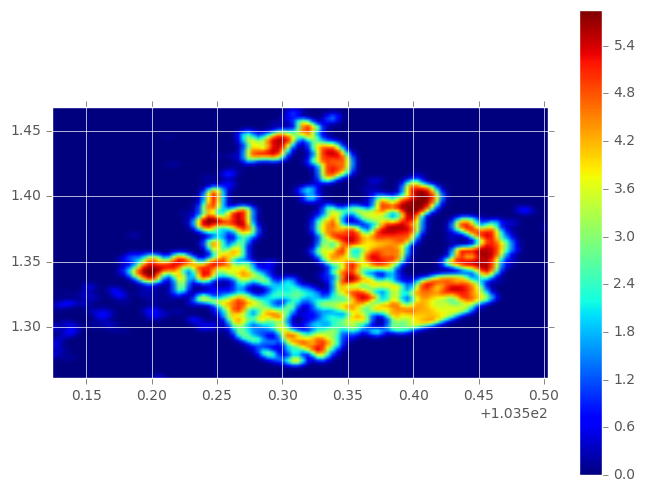

In [40]:
heatmap(vpclldd_df, bins=100, smoothing=1.0)

Moved the participant heatmap generation down here to where the point geometry has been defined.

In [36]:
def smaller_dist_bin(dist):
    if dist < 0.2:
        return '< 0.2'
    elif dist < 0.4:
        return '0.2 - 0.4'
    elif dist < 0.6:
        return '0.4 - 0.6'
    elif dist < 0.8:
        return '0.6 - 0.8'
    elif dist < 1.0:
        return '0.8 - 1.0'
    else:
        return '>1.0'

In [37]:
totalcount = len(vpclldd_df)
vpclldd_df['smaller_distbin'] = vpclldd_df['directdist'].apply(lambda x: smaller_dist_bin(x))
smallbin_vpclldd_df = vpclldd_df['smaller_distbin'].groupby(vpclldd_df['smaller_distbin']).count().to_frame()
smallbin_vpclldd_df.rename(columns = {'smaller_distbin':'count'}, inplace = True)
smallbin_vpclldd_df['percentage'] = smallbin_vpclldd_df['count'].apply(lambda x: str(round(x/totalcount * 100,2)) + '%')

smallbin_vpclldd_df['reorder_tmp'] = range(1,len(smallbin_vpclldd_df)+1)
smallbin_vpclldd_df.ix[4,'reorder_tmp'] = 0
smallbin_vpclldd_df.sort_values(by="reorder_tmp", inplace=True)
smallbin_vpclldd_df.drop('reorder_tmp', axis=1, inplace=True)
print(smallbin_vpclldd_df)

                 count percentage
smaller_distbin                  
< 0.2            25679      8.56%
0.2 - 0.4        63569     21.18%
0.4 - 0.6        59614     19.86%
0.6 - 0.8        50361     16.78%
0.8 - 1.0        36762     12.25%
>1.0             64142     21.37%


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


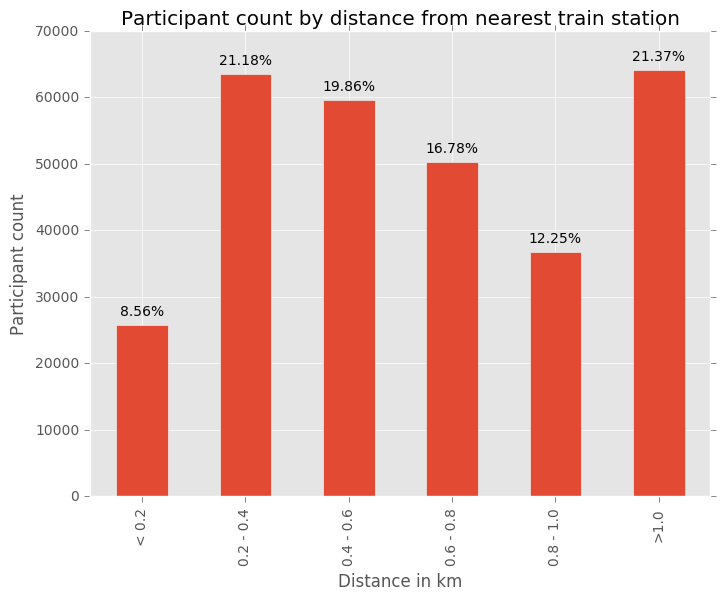

In [38]:
ax = smallbin_vpclldd_df.plot(kind='bar', legend=None, title='Participant count by distance from nearest train station')
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height()/totalcount*100,2)) + '%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel("Distance in km")
plt.ylabel("Participant count")
plt.show()

In [39]:
export_for_labelling_df = stackstn_by_dist_df
# export_for_labelling_df.drop('cluster', axis=1, inplace=True)
export_for_labelling_df.to_csv('breakdown.csv')

In [55]:
hdb_or_no_df = vpclldd_df[['EncNRIC', 'postalcode', "smaller_distbin"]]
hdb_or_no_df

EncNRIC postalcode smaller_distbin
0       +++dRFewDCP35Ewg/Hxs0A==     400336       0.6 - 0.8
1       ++/KfZFlfVuQNZJvDuDafQ==     546183       0.8 - 1.0
2       ++08DjepMTLJ7yMy6b8tOg==     578345            >1.0
3       ++0kjCLiS480sqIsQ/3GwA==     650420       0.8 - 1.0
4       ++0znnPR1z8lmQnhF2Sfpg==     460059       0.8 - 1.0
6       ++2O1MJu2/uGAYpnA6IXBA==     466507            >1.0
7       ++2b52HGYQoZWfUx5UARJA==     357984       0.6 - 0.8
8       ++5VrZG2Zt+rwgJFqv3V3Q==     760776       0.4 - 0.6
9       ++5mkKs7u+tkcSHgaBGIZQ==     560129       0.8 - 1.0
10      ++8m2GXucH+pHlYEHpoXSw==     732685       0.4 - 0.6
11      ++8sSVLMf1+NfCO7yQkO3g==     669558           < 0.2
12      ++9LeJSHRV9kYw2V4GtrKg==     737785       0.8 - 1.0
13      ++9PVXKzU2pcu4GY+Pc/GQ==     330004       0.4 - 0.6
14      ++9VtS3ZO7yowXl5a5Iakw==     531470       0.4 - 0.6
15      ++9zWrp73kWJ5AkyxUMvPQ==     684686       0.6 - 0.8
16      ++AUajbApEYfCKctu8Y8cw==     760150       0.2 - 0.4
17      ++Bsi82Yg6ABh6wEjKHy2g==     640489       0.8 - 1.0
18      ++ClrSQWcLaUYTVbqw76iA==     798595       0.4 - 0.6
19      ++CtzbW94oP22YF3mDUH7w==     828785       0.2 - 0.4
20      ++EJ2VSbJdWzeWFVI+eBUQ==     540142           < 0.2
21      ++EUvaXXhCOABr/fLdRhyg==     543124       0.2 - 0.4
22      ++FeAgN+I36UTmiGJMlHNQ==     550407       0.2 - 0.4
23      ++GoFUfQj2b90xvS8Xpk5A==     670183           < 0.2
24      ++I12rLI8tpYu2e3KZVvlA==     510709            >1.0
25      ++IBue/eu2lw6YcVwJxp9Q==     760797       0.2 - 0.4
26      ++ID6s05fVu2RKD/LxPU0Q==     315079       0.2 - 0.4
28      ++J/vHEWj0GZbooJtKENJg==     275018       0.4 - 0.6
29      ++JEzzhqtZAbxvkKHWkJng==     310153       0.2 - 0.4
30      ++JiS0xlCXsfRDOFNqaLgA==     160043       0.4 - 0.6
32      ++N9czw5AVY0yBer0jnoYA==     270026       0.4 - 0.6
...                          ...        ...             ...
339089  zzcJD2qHiBTMuI356TSJpQ==     689676       0.2 - 0.4
339090  zzcmur7NW3WfGAsLC5hkFg==     321019       0.8 - 1.0
339091  zzeIuPEj5VOkJkxsdKdPoA==     640642       0.2 - 0.4
339092  zzeS+VYqeMu1aGZ4rqRaeQ==     642686       0.4 - 0.6
339093  zzfTMo7v6KRGZrVF1bz7Dw==     152120       0.6 - 0.8
339094  zzfceoJloV2sWrIc+bV0TA==     142091       0.2 - 0.4
339095  zzfx4Y/Tc/++jc0+xrQeUA==     131028       0.8 - 1.0
339096  zzgiKGFsauO0TKNPE+YWog==     600330       0.8 - 1.0
339098  zzhGBFGS3Na+mfocXjbCwA==     561253            >1.0
339099  zzi986HT+Uu8sQ3wqAwpTg==     650507       0.6 - 0.8
339100  zzl8r2z2JVbpSFfVv5eBZw==     763334            >1.0
339101  zzlEYXtGuqvXSiyshAKt5w==     380016       0.4 - 0.6
339102  zzlyZifHqOxN/LWd9yllyQ==     522878            >1.0
339103  zzmTP3n7OfVFvpRUdyLGUg==     530458       0.6 - 0.8
339104  zzmj97M3MYS1EFE2/ecVmg==     730035            >1.0
339105  zzq4XdMFjYSyjkP+vHIZAw==     640848            >1.0
339106  zzqrTyoNCOfx62ZjbJHfyQ==     683688       0.6 - 0.8
339107  zzr0JjU7qeYOkqhOtyl1+g==     569786       0.4 - 0.6
339108  zzrTLeXRFb78FeQGw1oppQ==     677723       0.2 - 0.4
339109  zzre5Sj2lxOSz+78pnhqWw==     640204       0.6 - 0.8
339110  zzt1FrninFN+Kvj4CPQd3g==     650241       0.4 - 0.6
339111  zztZnpNMXPMCwyMWNGDDhw==     680669       0.6 - 0.8
339112  zzu3OsvK4QHUV8cy5f5ouw==     670135       0.2 - 0.4
339114  zzwCwaFoB1Eev/zgCFIk6g==     579208       0.2 - 0.4
339115  zzwVwdPgFTq54UIJ58T/QA==     470766            >1.0
339116  zzwjbHU2Seaod95mjbD57w==     469752       0.4 - 0.6
339117  zzwsiMnZ2GzLuo5ZDTLyWw==     560605       0.8 - 1.0
339118  zzxLoXI8B7dlRWZdRBwQjQ==     570214       0.6 - 0.8
339119  zzxPX95GXuTBjE/orKqXcw==     520926       0.8 - 1.0
339120  zzzc9Bqb+mm/Yg1Yoamgnw==     670506           < 0.2

[300127 rows x 3 columns]

In [56]:
hdb_df = pd.read_csv(os.path.join(os.pardir, 'data', 'HDB layer.csv'), dtype={'POSTALCODE': str})
hdb_df

X           Y POSTALCODE
0     18916.4427  40208.6805     680136
1     19014.8019  40264.5701     680141
2     18945.1925  40306.4677     680142
3     21464.0735  46154.5364     730159
4     22732.4725  47039.4739     730801
5     22735.8463  46957.4282     730802
6     22855.9587  46892.2283     730803
7     22931.3818  46850.1614     730804
8     22879.9073  46926.9965     730805
9     22903.0227  47103.3813     730807
10    22836.0667  47105.7017     730808
11    26163.9509  48506.6350     750489
12    26210.7913  48545.1754     750490
13    25970.7977  47918.4726     752359
14    28900.1705  45686.0748     760320
15    28913.6524  45623.7651     760321
16    28885.0454  45546.3126     760323
17    28966.0542  45599.6484     760324
18    28982.3268  45663.4563     760325
19    29015.0480  45698.0098     760326
20    29010.2312  45755.5149     760327
21    29083.7334  45723.2762     760328
22    29034.9046  45780.9639     760329
23    29030.0790  45851.7750     760330
24    29083.3605  45815.4500     760331
25    29129.3301  45799.3865     760332
26    24637.7808  30367.7179     140170
27    25378.1306  30900.8185     141087
28    25323.0222  30907.8438     142088
29    31461.2213  31814.3851     190006
...          ...         ...        ...
9498  36492.1163  41950.6710     822110
9499  36656.7300  41827.7889     822126
9500  36854.4819  41655.1917     822128
9501  37201.4225  41902.6001     822160
9502  37124.1094  41957.6023     822161
9503  37038.6235  42018.3528     822162
9504  36953.4154  41947.3669     822163
9505  37030.7583  41891.8402     822165
9506  37116.2165  41831.0377     822166
9507  37087.5442  41792.2251     822167
9508  36976.4433  41821.9553     822168
9509  36986.3147  41681.3743     822169
9510  37056.7827  41693.8803     822170
9511  36836.0527  41875.1682     822171
9512  36734.5365  41957.7317     822172
9513  36540.6353  42049.0877     822173
9514  36624.0874  42069.1723     822174
9515  36383.1090  42184.0132     822175
9516  36367.6906  42271.0162     822176
9517  36142.5046  42582.2391     822195
9518  36198.7007  42320.7424     822196
9519  36160.5299  42445.0718     822197
9520  36060.7721  42427.2069     822199
9521  35849.5515  42428.0921     822201
9522  35896.7792  42345.9070     822202
9523  35807.6396  42214.7227     822203
9524  35778.1019  42284.8068     822204
9525  35502.5689  42466.5119     822207
9526  35546.1804  42581.0640     822208
9527  35524.8422  42400.7122     822209

[9528 rows x 3 columns]

In [57]:
print(type(hdb_or_no_df['postalcode'][0]))
print(type(hdb_df['POSTALCODE'][0]))

<class 'str'>
<class 'str'>


In [65]:
print('683688' in hdb_df['POSTALCODE']) #checks the index of hdb_df['POSTALCODE'}], which is why it returns false for all
print('683688' in hdb_df['POSTALCODE'].values)

False
True


In [66]:
%%time
hdb_or_no_df['isHDB'] = hdb_or_no_df['postalcode'].apply(lambda pc: pc in hdb_df['POSTALCODE'].values)
hdb_or_no_df

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


EncNRIC postalcode smaller_distbin  isHDB
0       +++dRFewDCP35Ewg/Hxs0A==     400336       0.6 - 0.8   True
1       ++/KfZFlfVuQNZJvDuDafQ==     546183       0.8 - 1.0  False
2       ++08DjepMTLJ7yMy6b8tOg==     578345            >1.0  False
3       ++0kjCLiS480sqIsQ/3GwA==     650420       0.8 - 1.0   True
4       ++0znnPR1z8lmQnhF2Sfpg==     460059       0.8 - 1.0   True
6       ++2O1MJu2/uGAYpnA6IXBA==     466507            >1.0  False
7       ++2b52HGYQoZWfUx5UARJA==     357984       0.6 - 0.8  False
8       ++5VrZG2Zt+rwgJFqv3V3Q==     760776       0.4 - 0.6   True
9       ++5mkKs7u+tkcSHgaBGIZQ==     560129       0.8 - 1.0   True
10      ++8m2GXucH+pHlYEHpoXSw==     732685       0.4 - 0.6   True
11      ++8sSVLMf1+NfCO7yQkO3g==     669558           < 0.2  False
12      ++9LeJSHRV9kYw2V4GtrKg==     737785       0.8 - 1.0  False
13      ++9PVXKzU2pcu4GY+Pc/GQ==     330004       0.4 - 0.6   True
14      ++9VtS3ZO7yowXl5a5Iakw==     531470       0.4 - 0.6   True
15      ++9zWrp73kWJ5AkyxUMvPQ==     684686       0.6 - 0.8   True
16      ++AUajbApEYfCKctu8Y8cw==     760150       0.2 - 0.4   True
17      ++Bsi82Yg6ABh6wEjKHy2g==     640489       0.8 - 1.0   True
18      ++ClrSQWcLaUYTVbqw76iA==     798595       0.4 - 0.6  False
19      ++CtzbW94oP22YF3mDUH7w==     828785       0.2 - 0.4  False
20      ++EJ2VSbJdWzeWFVI+eBUQ==     540142           < 0.2   True
21      ++EUvaXXhCOABr/fLdRhyg==     543124       0.2 - 0.4   True
22      ++FeAgN+I36UTmiGJMlHNQ==     550407       0.2 - 0.4   True
23      ++GoFUfQj2b90xvS8Xpk5A==     670183           < 0.2   True
24      ++I12rLI8tpYu2e3KZVvlA==     510709            >1.0   True
25      ++IBue/eu2lw6YcVwJxp9Q==     760797       0.2 - 0.4   True
26      ++ID6s05fVu2RKD/LxPU0Q==     315079       0.2 - 0.4   True
28      ++J/vHEWj0GZbooJtKENJg==     275018       0.4 - 0.6   True
29      ++JEzzhqtZAbxvkKHWkJng==     310153       0.2 - 0.4   True
30      ++JiS0xlCXsfRDOFNqaLgA==     160043       0.4 - 0.6   True
32      ++N9czw5AVY0yBer0jnoYA==     270026       0.4 - 0.6   True
...                          ...        ...             ...    ...
339089  zzcJD2qHiBTMuI356TSJpQ==     689676       0.2 - 0.4  False
339090  zzcmur7NW3WfGAsLC5hkFg==     321019       0.8 - 1.0   True
339091  zzeIuPEj5VOkJkxsdKdPoA==     640642       0.2 - 0.4   True
339092  zzeS+VYqeMu1aGZ4rqRaeQ==     642686       0.4 - 0.6   True
339093  zzfTMo7v6KRGZrVF1bz7Dw==     152120       0.6 - 0.8   True
339094  zzfceoJloV2sWrIc+bV0TA==     142091       0.2 - 0.4   True
339095  zzfx4Y/Tc/++jc0+xrQeUA==     131028       0.8 - 1.0   True
339096  zzgiKGFsauO0TKNPE+YWog==     600330       0.8 - 1.0   True
339098  zzhGBFGS3Na+mfocXjbCwA==     561253            >1.0   True
339099  zzi986HT+Uu8sQ3wqAwpTg==     650507       0.6 - 0.8   True
339100  zzl8r2z2JVbpSFfVv5eBZw==     763334            >1.0   True
339101  zzlEYXtGuqvXSiyshAKt5w==     380016       0.4 - 0.6   True
339102  zzlyZifHqOxN/LWd9yllyQ==     522878            >1.0   True
339103  zzmTP3n7OfVFvpRUdyLGUg==     530458       0.6 - 0.8   True
339104  zzmj97M3MYS1EFE2/ecVmg==     730035            >1.0   True
339105  zzq4XdMFjYSyjkP+vHIZAw==     640848            >1.0   True
339106  zzqrTyoNCOfx62ZjbJHfyQ==     683688       0.6 - 0.8   True
339107  zzr0JjU7qeYOkqhOtyl1+g==     569786       0.4 - 0.6  False
339108  zzrTLeXRFb78FeQGw1oppQ==     677723       0.2 - 0.4  False
339109  zzre5Sj2lxOSz+78pnhqWw==     640204       0.6 - 0.8   True
339110  zzt1FrninFN+Kvj4CPQd3g==     650241       0.4 - 0.6   True
339111  zztZnpNMXPMCwyMWNGDDhw==     680669       0.6 - 0.8   True
339112  zzu3OsvK4QHUV8cy5f5ouw==     670135       0.2 - 0.4   True
339114  zzwCwaFoB1Eev/zgCFIk6g==     579208       0.2 - 0.4  False
339115  zzwVwdPgFTq54UIJ58T/QA==     470766            >1.0   True
339116  zzwjbHU2Seaod95mjbD57w==     469752       0.4 - 0.6  False
339117  zzwsiMnZ2GzLuo5ZDTLyWw==     560605       0.8 - 1.0   True
339118  zzxLoXI8B7dlRWZdRBwQjQ==     570214       0.6 - 0.8   True
33911

                       count percentage
smaller_distbin isHDB                  
0.2 - 0.4       False   9807      3.27%
                True   53762     17.91%
0.4 - 0.6       False  10674      3.56%
                True   48940     16.31%
0.6 - 0.8       False   9605       3.2%
                True   40756     13.58%
0.8 - 1.0       False   7274      2.42%
                True   29488      9.83%
< 0.2           False   3172      1.06%
                True   22507       7.5%
>1.0            False  17664      5.89%
                True   46478     15.49%


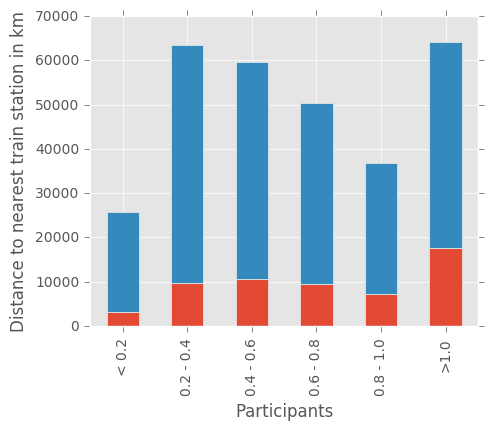

In [103]:
#hdb_or_no_df.loc[hdb_or_no_df['isHDB'] == True]
hdb_distbin_df = hdb_or_no_df.groupby(['smaller_distbin', 'isHDB'])['EncNRIC'].count().to_frame('count')
totalparti = hdb_distbin_df['count'].sum()
hdb_distbin_df['percentage'] = hdb_distbin_df['count'].apply(lambda c: str(round(c/totalparti*100, 2)) + '%')
print(hdb_distbin_df)

hdb_distbin_plot_df = hdb_distbin_df.unstack('isHDB').reindex(['< 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1.0', '>1.0'])

ax = hdb_distbin_plot_df.plot(kind='bar', stacked=True, figsize=(5,4), legend=None)
  
plt.xlabel("Participants")
plt.ylabel("Distance to nearest train station in km")
plt.show()
